In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import re

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [2]:
stock = {}
stock['FPT'] = pd.read_csv("FPT Corp Stock Price History.csv")
stock['HPG'] = pd.read_csv("Hoa Phat Group JSC Stock Price History.csv")
stock['VCB'] = pd.read_csv("Vietcombank Stock Price History.csv")
stock['VNM'] = pd.read_csv("Vinamilk Stock Price History.csv")
stock['MWG'] = pd.read_csv("Mobile World Investment Corp Stock Price History.csv")
for key, item in stock.items():
    print(f"Giá cổ phiếu: {key}")
    print(item.head())

Giá cổ phiếu: FPT
         Date      Price       Open       High        Low   Vol. Change %
0  11/28/2024  139,500.0  138,900.0  140,000.0  132,000.0  1.45M   10.89%
1  11/27/2024  125,800.0  135,200.0  139,600.0  125,800.0  9.81M   -6.95%
2  11/26/2024  135,200.0  133,400.0  135,900.0  133,300.0  4.50M    0.97%
3  11/25/2024  133,900.0  134,000.0  134,000.0  133,200.0  6.64M    0.00%
4  11/22/2024  133,900.0  132,900.0  134,400.0  132,500.0  5.58M    0.68%
Giá cổ phiếu: HPG
         Date     Price      Open      High       Low    Vol. Change %
0  11/28/2024  26,550.0  24,500.0  26,750.0  24,500.0   5.09M   -5.18%
1  11/27/2024  28,000.0  26,350.0  28,100.0  25,430.0   7.97M    6.26%
2  11/26/2024  26,350.0  26,300.0  26,500.0  26,200.0  14.57M    0.19%
3  11/25/2024  26,300.0  26,100.0  26,300.0  26,050.0  18.87M    0.77%
4  11/22/2024  26,100.0  25,900.0  26,250.0  25,850.0  18.45M    0.97%
Giá cổ phiếu: VCB
         Date   Price    Open    High     Low     Vol. Change %
0  11/28/202

In [3]:
for key, item in stock.items():
    print(f"Giá cổ phiếu: {key}")
    print(item.tail())

Giá cổ phiếu: FPT
            Date     Price      Open      High       Low    Vol. Change %
2555  09/09/2014  13,872.3  14,622.2  14,622.2  13,622.4  12.04M   -5.13%
2556  09/08/2014  14,622.2  14,622.2  14,872.1  14,497.2   7.23M    0.86%
2557  09/05/2014  14,497.2  14,247.2  14,497.2  14,247.2   6.19M    1.75%
2558  09/04/2014  14,247.2  14,122.3  14,247.2  13,997.3   4.25M    0.00%
2559  09/03/2014  14,247.2  14,497.2  14,622.2  14,122.3   5.36M   -0.87%
Giá cổ phiếu: HPG
            Date    Price     Open     High      Low    Vol. Change %
2555  09/09/2014  5,083.4  5,169.5  5,212.6  4,997.2  17.11M   -3.28%
2556  09/08/2014  5,255.7  5,255.7  5,298.8  5,212.6   9.67M    0.00%
2557  09/05/2014  5,255.7  5,212.6  5,255.7  5,169.5   4.99M    0.00%
2558  09/04/2014  5,255.7  5,126.4  5,341.8  5,126.4  18.89M    2.52%
2559  09/03/2014  5,126.4  5,040.3  5,126.4  5,040.3  11.52M    2.59%
Giá cổ phiếu: VCB
            Date   Price    Open    High     Low     Vol. Change %
2555  09/09/201

In [4]:
for key, item in stock.items():
    print(f"Giá cổ phiếu: {key}")
    print(item.info())

Giá cổ phiếu: FPT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2560 non-null   object
 1   Price     2560 non-null   object
 2   Open      2560 non-null   object
 3   High      2560 non-null   object
 4   Low       2560 non-null   object
 5   Vol.      2559 non-null   object
 6   Change %  2560 non-null   object
dtypes: object(7)
memory usage: 140.1+ KB
None
Giá cổ phiếu: HPG
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2560 non-null   object
 1   Price     2560 non-null   object
 2   Open      2560 non-null   object
 3   High      2560 non-null   object
 4   Low       2560 non-null   object
 5   Vol.      2559 non-null   object
 6   Change %  2560 non-null   object
dtypes: object(7)
mem

In [5]:
full_date_range = pd.date_range(start='2014-09-03', end='2024-11-28')
date_length = len(full_date_range)
print(f"Số ngày: {date_length}")
for key,value in stock.items():
    print(f"Số ngày giao dịch cổ phiếu {key} bị thiếu: {date_length-len(stock[key]['Date'])}")

Số ngày: 3740
Số ngày giao dịch cổ phiếu FPT bị thiếu: 1180
Số ngày giao dịch cổ phiếu HPG bị thiếu: 1180
Số ngày giao dịch cổ phiếu VCB bị thiếu: 1180
Số ngày giao dịch cổ phiếu VNM bị thiếu: 1180
Số ngày giao dịch cổ phiếu MWG bị thiếu: 1180


Theo như bảng thông tin trên, tất cả các cột đều bị khuyết thiếu giá trị và các cột đều chưa đúng định dạng mà chúng nên có: tất cả đều có định dạng là object thay vì dạng datetime cho cột `Date` và dạng số cho các cột khác. Hơn nữa, còn rất nhiều ngày giao dịch bị thiếu trong bộ dữ liệu: cụ thể là 1180 ngày.

In [7]:
for key, value in stock.items():
    stock[key]['Date'] = pd.to_datetime(stock[key]['Date'])
    missing_dates = full_date_range.difference(stock[key]['Date'])
    print(f"Các ngày bị thiếu với cổ phiếu {key}:")
    print(missing_dates)

Các ngày bị thiếu với cổ phiếu FPT:
DatetimeIndex(['2014-09-06', '2014-09-07', '2014-09-13', '2014-09-14',
               '2014-09-20', '2014-09-21', '2014-09-27', '2014-09-28',
               '2014-10-04', '2014-10-05',
               ...
               '2024-10-26', '2024-10-27', '2024-11-02', '2024-11-03',
               '2024-11-09', '2024-11-10', '2024-11-16', '2024-11-17',
               '2024-11-23', '2024-11-24'],
              dtype='datetime64[ns]', length=1180, freq=None)
Các ngày bị thiếu với cổ phiếu HPG:
DatetimeIndex(['2014-09-06', '2014-09-07', '2014-09-13', '2014-09-14',
               '2014-09-20', '2014-09-21', '2014-09-27', '2014-09-28',
               '2014-10-04', '2014-10-05',
               ...
               '2024-10-26', '2024-10-27', '2024-11-02', '2024-11-03',
               '2024-11-09', '2024-11-10', '2024-11-16', '2024-11-17',
               '2024-11-23', '2024-11-24'],
              dtype='datetime64[ns]', length=1180, freq=None)
Các ngày bị thiếu với cổ

## Tiền xử lý dữ liệu

In [9]:
def transform_date(x):
    missing_dates = full_date_range.difference(x['Date'])
    missing_dates = pd.DataFrame({'Date': missing_dates})
    stock = pd.concat([x, missing_dates], ignore_index=True)
    stock['Date'] = pd.to_datetime(stock['Date'])  
    stock = stock.sort_values(by='Date').reset_index(drop=True)    
    return stock
for key, value in stock.items():
    stock[key] = transform_date(stock[key])
    print(f"Giá cổ phiếu: {key}")
    print(stock[key].head())
    print(stock[key].info())
    print(stock[key].isnull().sum())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low   Vol. Change %
0 2014-09-03  14,247.2  14,497.2  14,622.2  14,122.3  5.36M   -0.87%
1 2014-09-04  14,247.2  14,122.3  14,247.2  13,997.3  4.25M    0.00%
2 2014-09-05  14,497.2  14,247.2  14,497.2  14,247.2  6.19M    1.75%
3 2014-09-06       NaN       NaN       NaN       NaN    NaN      NaN
4 2014-09-07       NaN       NaN       NaN       NaN    NaN      NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3740 non-null   datetime64[ns]
 1   Price     2560 non-null   object        
 2   Open      2560 non-null   object        
 3   High      2560 non-null   object        
 4   Low       2560 non-null   object        
 5   Vol.      2559 non-null   object        
 6   Change %  2560 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usag

Ở các `Price`, `Open`, `High`, `Low` các giá trị đều đang ở dạng object thay vì dạng số và các số chứa dấu `,` khiến chúng không thể ở dạng số. Vấn đề này cũng xảy ra tương tự với cột `Change %`, tuy nhiên ở cột này cần loại bỏ kí hiệu `%`

In [11]:
def object_to_numeric(x):
    price_col=['Price','Open','High','Low']
    x[price_col] = x[price_col].replace(',','',regex=True)
    x[price_col] = x[price_col].apply(pd.to_numeric)
    x['Change %'] = x['Change %'].replace('%','',regex=True)
    x['Change %'] = x['Change %'].apply(pd.to_numeric)
    return x
for key, value in stock.items():
    stock[key] = object_to_numeric(stock[key])
    print(f"Giá cổ phiếu: {key}")
    print(stock[key].head())
    print(stock[key].info())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low   Vol.  Change %
0 2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30  5.36M     -0.87
1 2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30  4.25M      0.00
2 2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20  6.19M      1.75
3 2014-09-06       NaN       NaN       NaN       NaN    NaN       NaN
4 2014-09-07       NaN       NaN       NaN       NaN    NaN       NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3740 non-null   datetime64[ns]
 1   Price     2560 non-null   float64       
 2   Open      2560 non-null   float64       
 3   High      2560 non-null   float64       
 4   Low       2560 non-null   float64       
 5   Vol.      2559 non-null   object        
 6   Change %  2560 non-null   float64       
dtypes: datetime64[ns](1), float64(5), obj

Cột cuối cùng không đúng định dạng là cột `Vol.`. Ở mỗi giá trị đều có đơn vị dạng chữ đi kèm nó. Việc đầu tiên là cần xem xét xem các đơn vị chữ gồm những đơn vị gì

In [13]:
def split_vol(vol):
    vol = str(vol)
    value = re.match(r"([\d\.]+)([A-Za-z]*)", vol)
    if value:
        number = float(value.group(1))
        unit = value.group(2)
    else:
        number, unit = None, None
    return number, unit
for k, v in stock.items():
    stock[k]['Vol.'], stock[k]['Unit'] = zip(*stock[k]['Vol.'].apply(split_vol))
    print(f"Giá cổ phiếu: {k}")
    print(v.head())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low  Vol.  Change %  Unit
0 2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30  5.36     -0.87     M
1 2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30  4.25      0.00     M
2 2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20  6.19      1.75     M
3 2014-09-06       NaN       NaN       NaN       NaN   NaN       NaN  None
4 2014-09-07       NaN       NaN       NaN       NaN   NaN       NaN  None
Giá cổ phiếu: HPG
        Date    Price     Open     High      Low  Vol.  Change %  Unit
0 2014-09-03 5,126.40 5,040.30 5,126.40 5,040.30 11.52      2.59     M
1 2014-09-04 5,255.70 5,126.40 5,341.80 5,126.40 18.89      2.52     M
2 2014-09-05 5,255.70 5,212.60 5,255.70 5,169.50  4.99      0.00     M
3 2014-09-06      NaN      NaN      NaN      NaN   NaN       NaN  None
4 2014-09-07      NaN      NaN      NaN      NaN   NaN       NaN  None
Giá cổ phiếu: VCB
        Date     Price      Open      High       Low   Vol.  Change % 

In [14]:
for k, v in stock.items():
    print(f"Giá cổ phiếu: {k}")
    print("Đơn vị của khối lượng giao dịch:")
    print(v['Unit'].unique())

Giá cổ phiếu: FPT
Đơn vị của khối lượng giao dịch:
['M' None 'K']
Giá cổ phiếu: HPG
Đơn vị của khối lượng giao dịch:
['M' None 'K']
Giá cổ phiếu: VCB
Đơn vị của khối lượng giao dịch:
['K' 'M' None]
Giá cổ phiếu: VNM
Đơn vị của khối lượng giao dịch:
['K' None 'M']
Giá cổ phiếu: MWG
Đơn vị của khối lượng giao dịch:
['K' None 'M']


Như đã thấy, ở tất cả các bảng, đơn vị của khối lượng giao dịch `Vol.` chỉ có thể là M(1.000.000) và K(1.000) và None(không có đơn vị). Nhóm sẽ áp dụng nghiên tắc này để biến đổi giá trị của cột `Vol.` cho phù hợp

In [16]:
def convert(number,unit):
    unit_map={'K':1_000,'M':1_000_000}
    return number*unit_map.get(unit,1)
for k,v in stock.items():
    v['Vol.'] = v.apply(lambda row: convert(row['Vol.'],row['Unit']),axis=1)
    stock[k] = stock[k].drop(columns = 'Unit')
    print(f"Giá cổ phiếu: {k}")
    print(v.head())
    print(v.info())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low         Vol.  Change %  \
0 2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30 5,360,000.00     -0.87   
1 2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30 4,250,000.00      0.00   
2 2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20 6,190,000.00      1.75   
3 2014-09-06       NaN       NaN       NaN       NaN          NaN       NaN   
4 2014-09-07       NaN       NaN       NaN       NaN          NaN       NaN   

   Unit  
0     M  
1     M  
2     M  
3  None  
4  None  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3740 non-null   datetime64[ns]
 1   Price     2560 non-null   float64       
 2   Open      2560 non-null   float64       
 3   High      2560 non-null   float64       
 4   Low       2560 non-null   float64       
 5   Vol.      2559

Như vậy các cột đều đã được chuyển về định dạng chuẩn cho việc phân tích và dựng mô hình

In [18]:
for k,v in stock.items():
    stock[k] = v.set_index('Date')
    print(f"Giá cổ phiếu: {k}")
    print(v.head())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low         Vol.  Change %
0 2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30 5,360,000.00     -0.87
1 2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30 4,250,000.00      0.00
2 2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20 6,190,000.00      1.75
3 2014-09-06       NaN       NaN       NaN       NaN          NaN       NaN
4 2014-09-07       NaN       NaN       NaN       NaN          NaN       NaN
Giá cổ phiếu: HPG
        Date    Price     Open     High      Low          Vol.  Change %
0 2014-09-03 5,126.40 5,040.30 5,126.40 5,040.30 11,520,000.00      2.59
1 2014-09-04 5,255.70 5,126.40 5,341.80 5,126.40 18,890,000.00      2.52
2 2014-09-05 5,255.70 5,212.60 5,255.70 5,169.50  4,990,000.00      0.00
3 2014-09-06      NaN      NaN      NaN      NaN           NaN       NaN
4 2014-09-07      NaN      NaN      NaN      NaN           NaN       NaN
Giá cổ phiếu: VCB
        Date     Price      Open      High       Low

Việc tiếp theo cần làm là điền các giá trị bị khuyết thiếu. Nhóm sẽ sử dụng các phương pháp điền giá trị khuyết thiếu khác nhau và sử dụng một mô hình Linear Regression để xem xét xem phương án nào hiệu quả nhất

In [20]:
def test_impute(x):
    test = {}
    # Loại bỏ giá trị null
    test['Del'] = x.dropna()
    # Điền giá trị trung bình
    test['Mean'] = x.fillna(x.mean())
    # Điền giá trị trung vị
    test['Median'] = x.fillna(x.median())
    # Điền giá trị mode
    test['Mode'] = x.fillna(x.mode().iloc[0])
    # Điền giá trị trước đó
    test['Ffill'] = x.fillna(method='ffill')
    test['Ffill'] = test['Ffill'].dropna()
    # Điền giá trị sau đó
    test['Bfill'] = x.fillna(method='bfill')
    test['Bfill'] = test['Bfill'].dropna()
    # Nội suy tuyến tính
    test['Interpolate'] = x.interpolate(method='linear')
    test['Interpolate'] = test['Interpolate'].dropna()
    result ={}
    for key, item in test.items():
        X = item.drop(columns = 'Price')
        y = item['Price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_result = {
            'MSE': round(mean_squared_error(y_test, y_pred),2),
            'MAE': round(mean_absolute_error(y_test, y_pred),2),
            'R2': round(r2_score(y_test, y_pred),2)
        }
        result[key] = model_result
    return result        

In [21]:
for key, value in stock.items():
    print(f"Cổ phiếu {key}")
    result = test_impute(value)
    result_df = pd.DataFrame(result).T
    print(result_df)    

Cổ phiếu FPT
                   MSE    MAE   R2
Del         167,050.16 229.07 1.00
Mean         99,259.66 157.70 1.00
Median       99,448.38 164.62 1.00
Mode        133,647.75 245.10 1.00
Ffill       138,634.12 224.83 1.00
Bfill       154,738.81 233.02 1.00
Interpolate 117,982.74 209.00 1.00
Cổ phiếu HPG
                  MSE    MAE   R2
Del         20,172.89  91.48 1.00
Mean        12,180.31  60.73 1.00
Median      12,291.57  66.55 1.00
Mode        31,134.84 127.14 1.00
Ffill       16,375.50  85.30 1.00
Bfill       16,646.53  87.09 1.00
Interpolate 14,966.66  80.83 1.00
Cổ phiếu VCB
                   MSE    MAE   R2
Del         150,539.66 267.88 1.00
Mean        104,548.64 187.24 1.00
Median      104,683.88 201.27 1.00
Mode        332,032.96 310.59 1.00
Ffill       156,500.33 274.10 1.00
Bfill       156,817.77 273.65 1.00
Interpolate 136,585.20 255.51 1.00
Cổ phiếu VNM
                   MSE    MAE   R2
Del         405,835.19 340.45 1.00
Mean        156,803.83 232.61 1.00
Median     

Dựa vào các kết quả hiển thị ở trên, có thể khẳng định phương pháp điền giá trị khuyết thiếu bằng giá trị trung bình của các cột sẽ cho mô hình có kết quả tối ưu nhất (MSE và MAE thấp nhất và R2 cao nhất). Vậy nên nhóm quyết định lựa chọn phương pháp điền giá trị khuyết thiếu bằng giá trị trung bình

In [23]:
for key, value in stock.items():
    stock[key] = value.fillna(value.mean())
    print(f"Cổ phiếu {key}")
    print(stock[key].head())
    print(stock[key].info())

Cổ phiếu FPT
               Price      Open      High       Low         Vol.  Change %
Date                                                                     
2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30 5,360,000.00     -0.87
2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30 4,250,000.00      0.00
2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20 6,190,000.00      1.75
2014-09-06 45,896.54 45,881.92 46,385.08 45,404.60 2,423,255.41      0.10
2014-09-07 45,896.54 45,881.92 46,385.08 45,404.60 2,423,255.41      0.10
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3740 entries, 2014-09-03 to 2024-11-28
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     3740 non-null   float64
 1   Open      3740 non-null   float64
 2   High      3740 non-null   float64
 3   Low       3740 non-null   float64
 4   Vol.      3740 non-null   float64
 5   Change %  3740 non-null   float64
dtypes: float64(6)
memory usage: 

Việc tiếp theo cần làm là kiểm tra xem bộ dữ liệu có giá trị ngoại lai (outlier) không

Cổ phiếu FPT


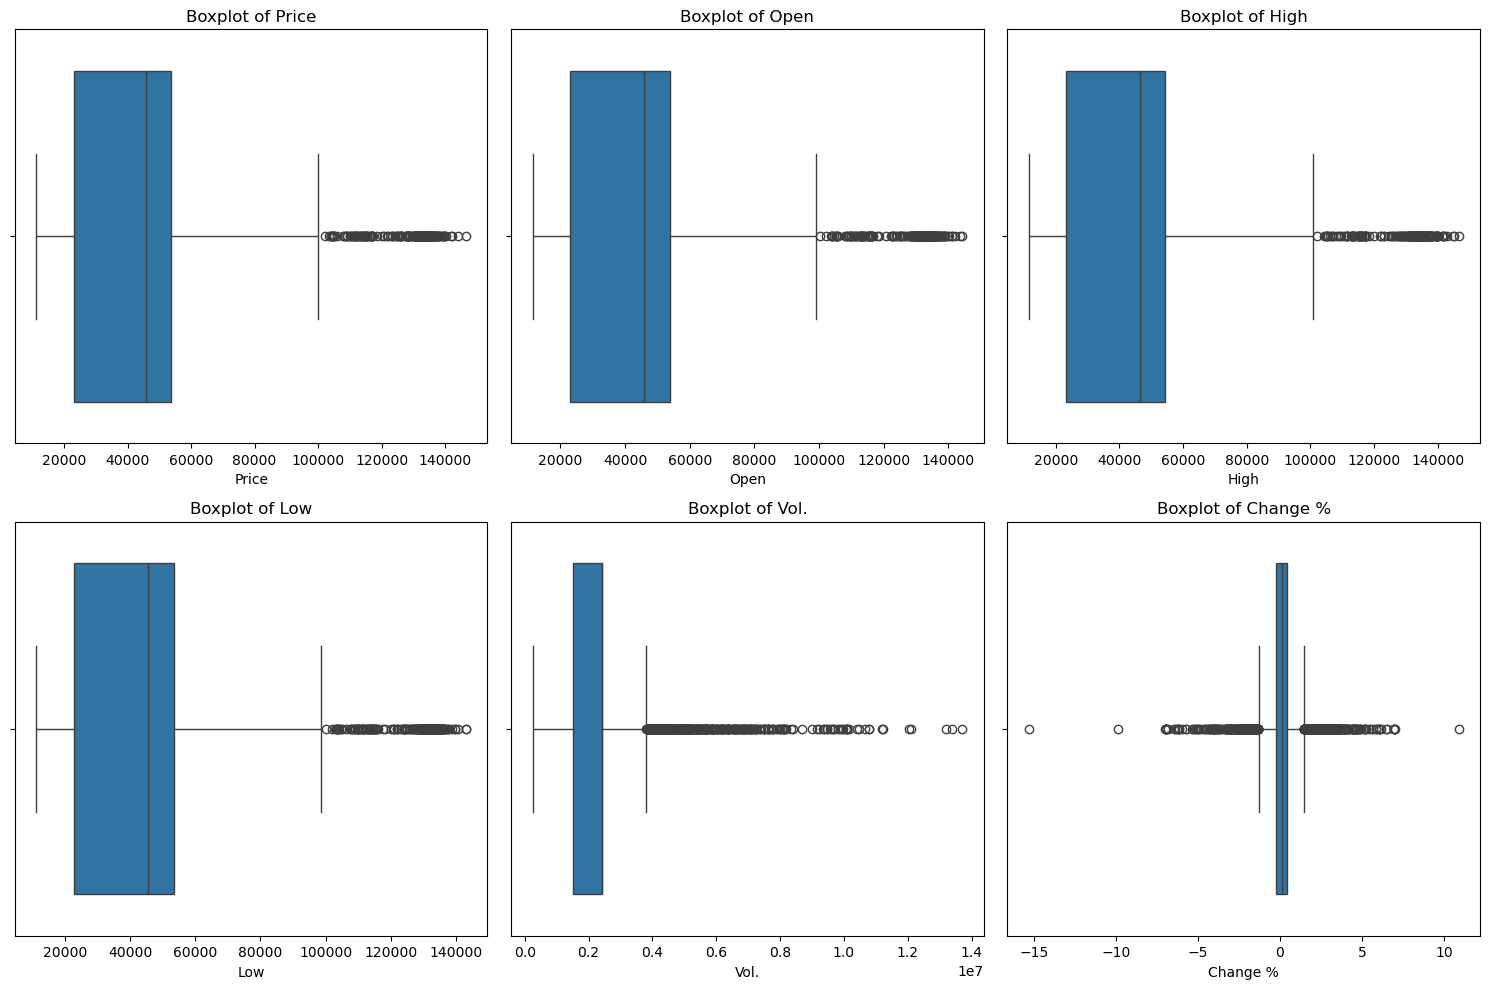

Cổ phiếu HPG


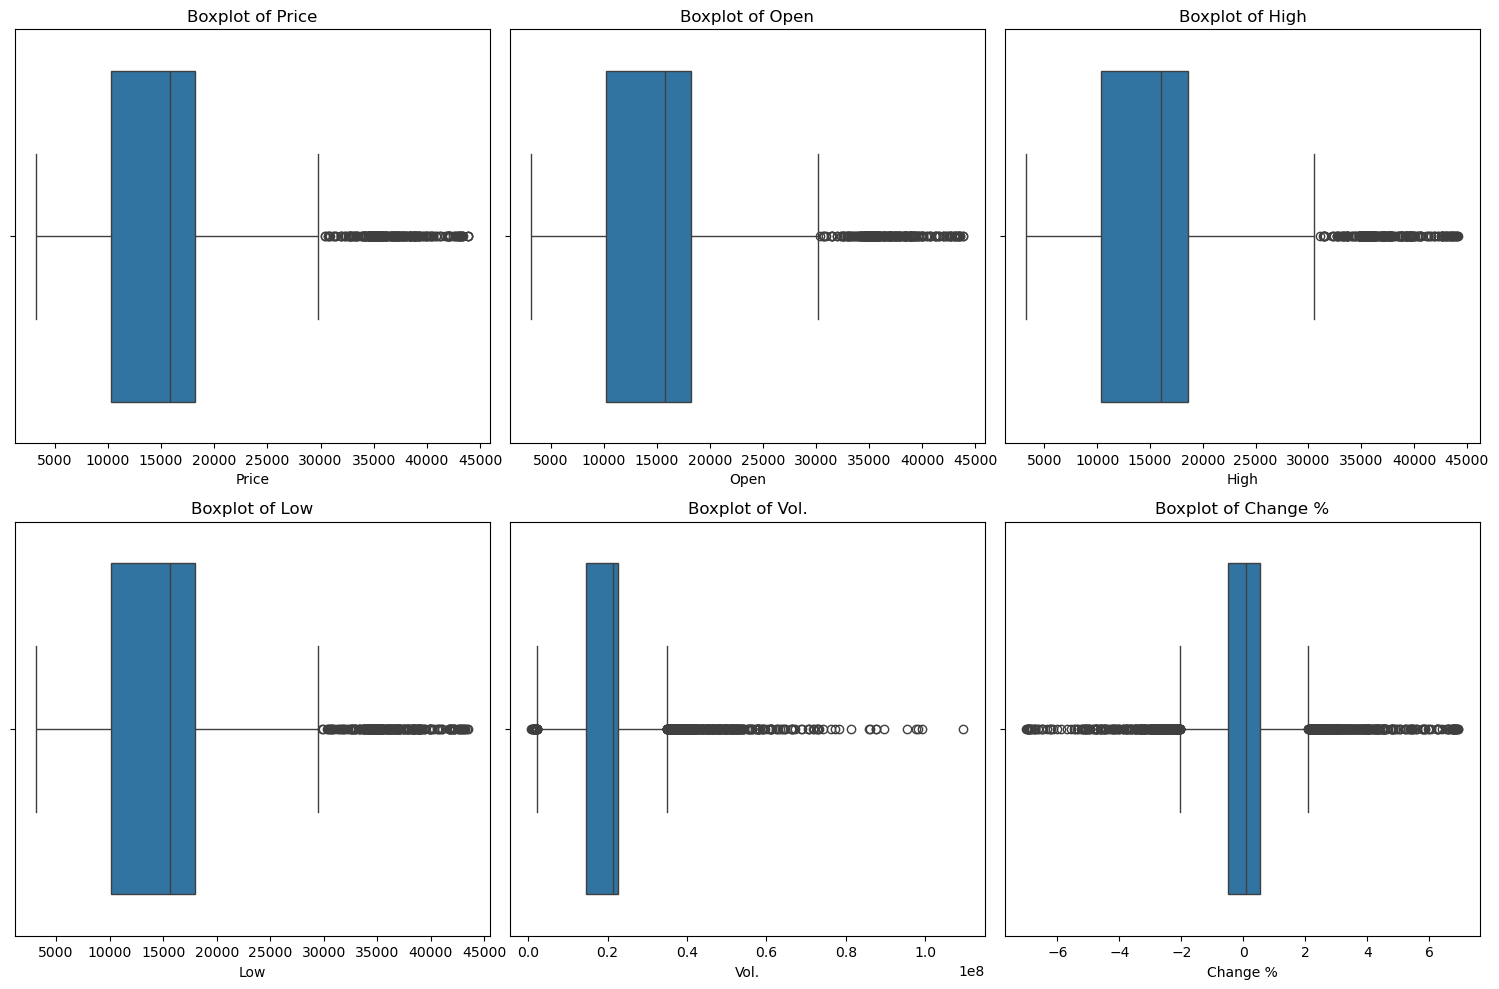

Cổ phiếu VCB


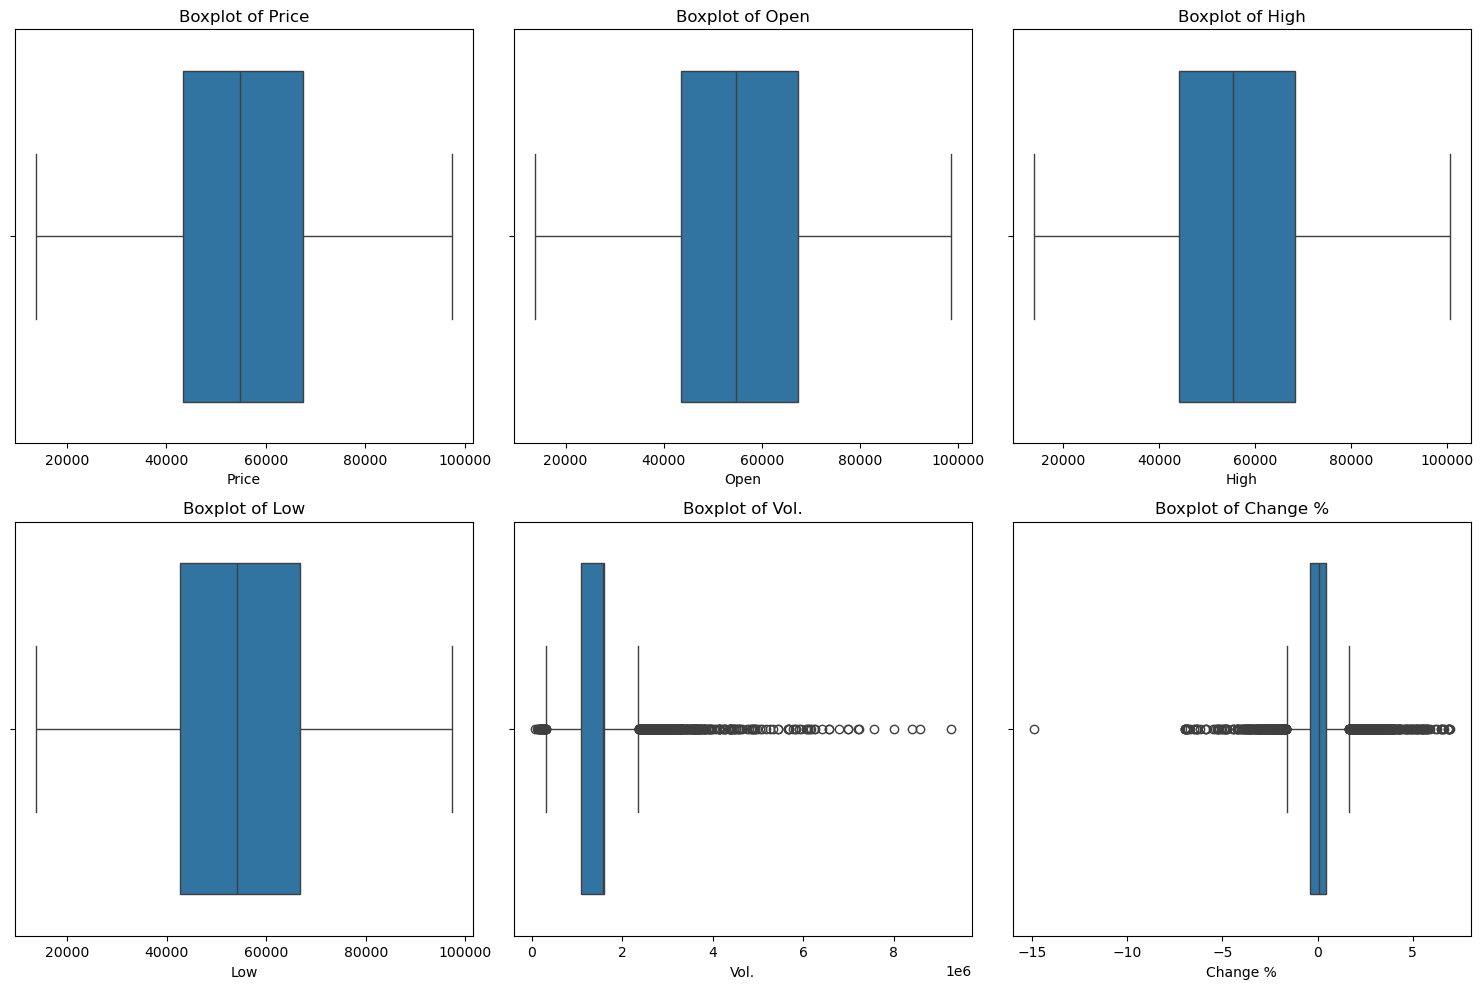

Cổ phiếu VNM


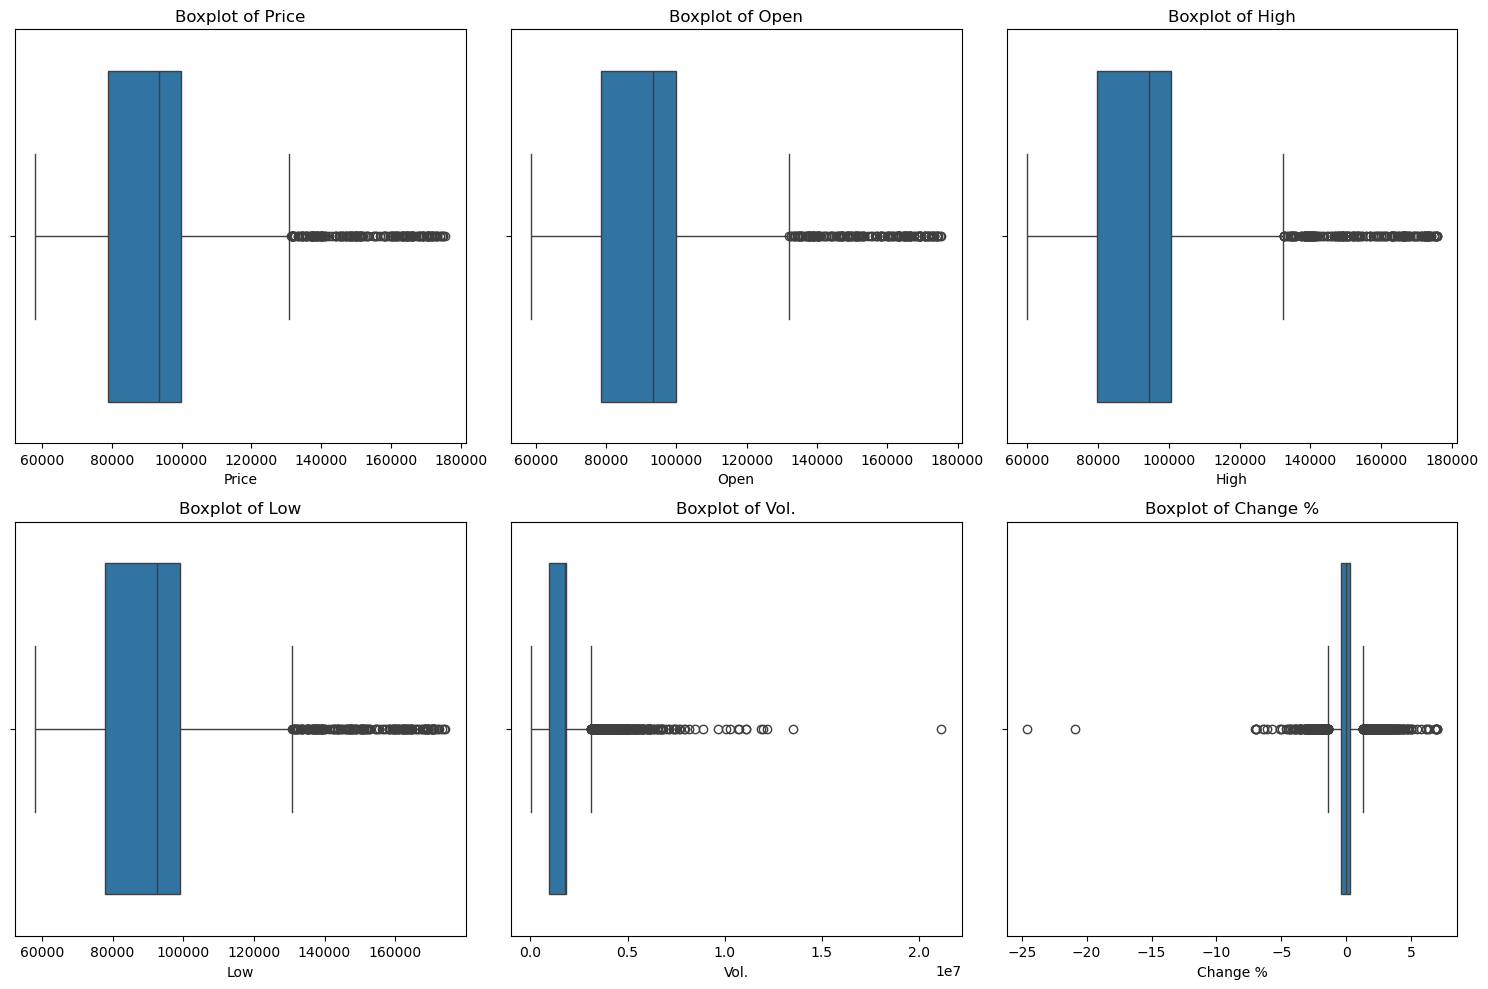

Cổ phiếu MWG


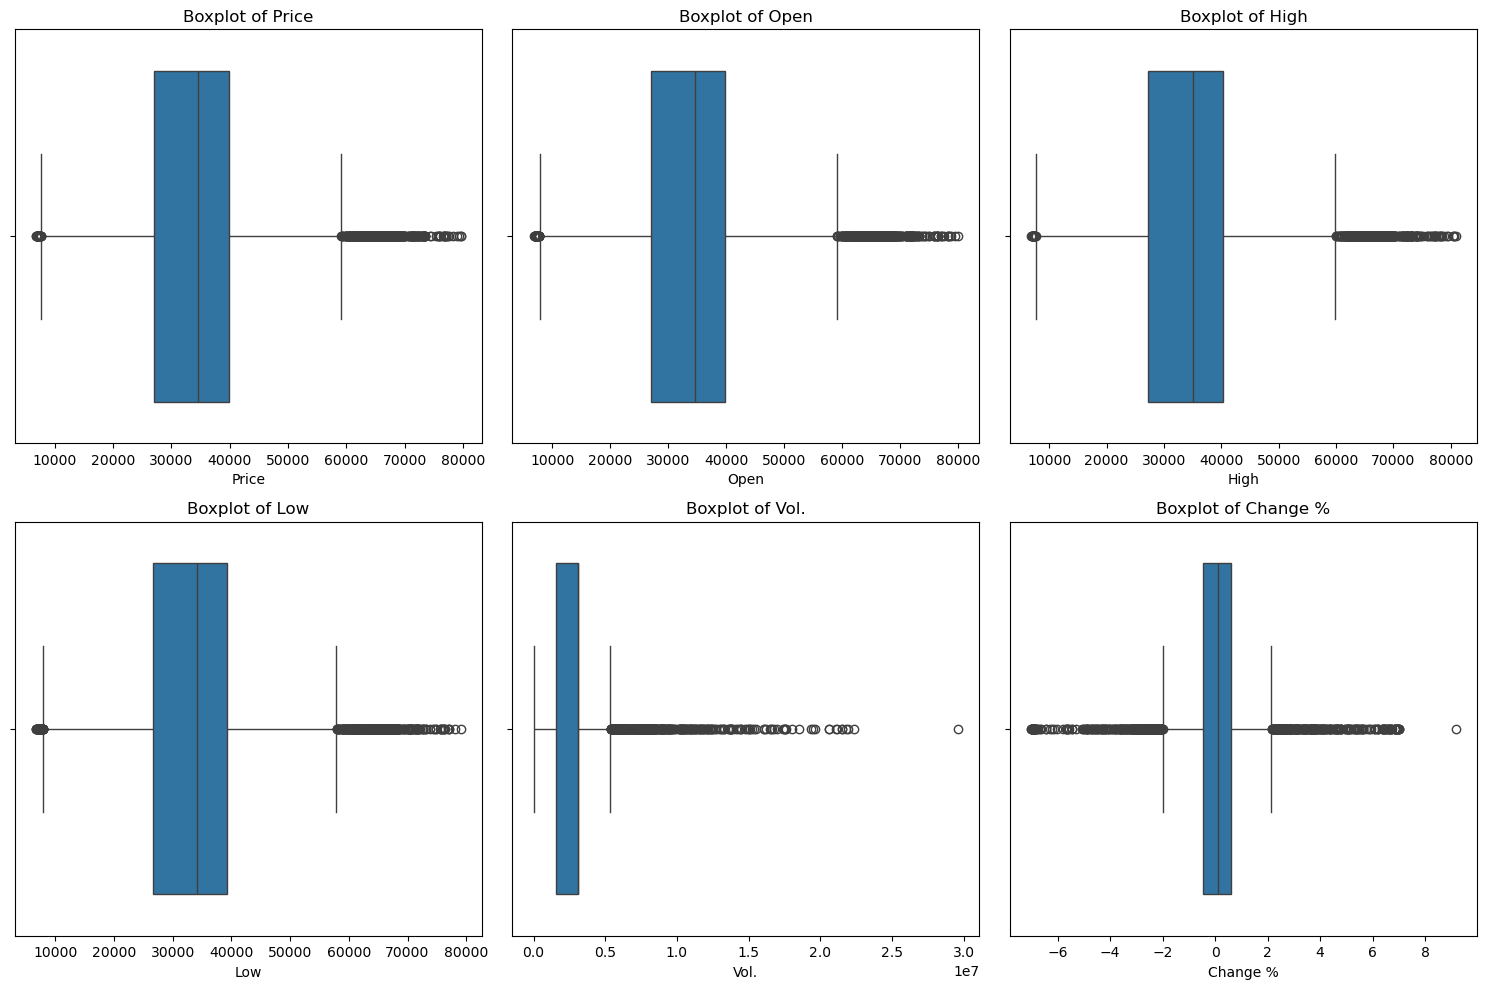

In [25]:
def box_plot(df):
    columns = df.columns.to_list()
    # Đặt số đồ thị mỗi hàng và số hàng
    num_cols = 3 
    num_rows = int(len(columns)/num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(data=df, x=col, ax=axes[i])  
        axes[i].set_title(f'Boxplot of {col}')  

    plt.tight_layout()
    plt.show()
for key, item in stock.items():
    print(f"Cổ phiếu {key}")
    box_plot(item)

Có thể thấy rằng bộ dữ liệu của 5 cổ phiếu bị lệch trái khá nhiều. Điều này có thể cho thấy có nhiều giá trị ngoại lai

# Exploratory Data Analysis

## 1. Mô tả sơ bộ về các cổ phiếu

In [29]:
for key,value in stock.items():
    print(f"Cổ phiếu {key}")
    print(value.describe())

Cổ phiếu FPT
           Price       Open       High        Low          Vol.  Change %
count   3,740.00   3,740.00   3,740.00   3,740.00      3,740.00  3,740.00
mean   45,896.54  45,881.92  46,385.08  45,404.60  2,423,255.41      0.10
std    28,808.90  28,794.35  29,122.48  28,461.54  1,473,753.86      1.35
min    11,297.80  11,372.80  11,572.80  11,197.80    241,980.00    -15.31
25%    23,042.80  23,016.70  23,244.78  22,905.90  1,500,000.00     -0.26
50%    45,896.54  45,881.92  46,385.08  45,404.60  2,423,255.41      0.10
75%    53,809.40  53,756.75  54,441.70  53,405.50  2,423,255.41      0.43
max   146,500.00 144,300.00 146,500.00 143,100.00 13,710,000.00     10.89
Cổ phiếu HPG
          Price      Open      High       Low           Vol.  Change %
count  3,740.00  3,740.00  3,740.00  3,740.00       3,740.00  3,740.00
mean  15,792.35 15,797.75 16,010.80 15,592.51  21,298,868.31      0.09
std    8,466.93  8,481.50  8,588.52  8,368.26  11,625,007.15      1.73
min    3,280.00  3,187.4

### 1. **Cổ phiếu FPT**
- **Giá trị trung bình**: 45,896 VNĐ, với mức giá cao nhất là **146,500 VNĐ** và thấp nhất là **11,298 VNĐ**.
- **Biến động lớn**: Độ lệch chuẩn khá cao (**28,809 VNĐ**), cho thấy cổ phiếu này có mức độ biến động đáng kể.
- **Thay đổi phần trăm nhỏ**: Trung bình thay đổi **0.10%**, với biên độ dao động từ **-15.31%** đến **10.89%**.
- **Khối lượng giao dịch trung bình**: ~2.4 triệu cổ phiếu mỗi phiên, với phiên cao nhất đạt hơn 13.7 triệu.

### 2. **Cổ phiếu HPG**
- **Giá trị trung bình**: 15,792 VNĐ, mức cao nhất là **43,896 VNĐ** và thấp nhất là **3,280 VNĐ**.
- **Biến động giá vừa phải**: Độ lệch chuẩn (**8,467 VNĐ**) cho thấy mức biến động thấp hơn rất nhiều so với FPT.
- **Khối lượng giao dịch lớn**: Trung bình hơn 21 triệu cổ phiếu mỗi phiên, cao nhất đạt **109.6 triệu** cổ phiếu.
- **Thay đổi phần trăm**: Trung bình **0.09%**, dao động từ **-7.00%** đến **6.94%**.

### 3. **Cổ phiếu VCB**
- **Giá trị trung bình**: 54,797 VNĐ, mức cao nhất là **97,400 VNĐ** và thấp nhất là **13,710 VNĐ**.
- **Biến động thấp hơn**: Độ lệch chuẩn (**20,385 VNĐ**) vừa phải.
- **Thay đổi phần trăm nhỏ**: Trung bình **0.09%**, dao động từ **-14.92%** đến **6.95%**.
- **Khối lượng giao dịch trung bình**: ~1.6 triệu cổ phiếu mỗi phiên.

### 4. **Cổ phiếu VNM**
- **Giá trị trung bình**: 93,442 VNĐ, cao nhất **175,578 VNĐ** và thấp nhất **58,115 VNĐ**.
- **Biến động thấp**: Độ lệch chuẩn (**20,445 VNĐ**) và thay đổi trung bình **0.01%** cho thấy tính ổn định cao.
- **Khối lượng giao dịch trung bình**: ~1.75 triệu cổ phiếu, thấp hơn so với các cổ phiếu khác.

### 5. **Cổ phiếu MWG**
- **Giá trị trung bình**: 34,626 VNĐ, mức cao nhất là **79,582 VNĐ** và thấp nhất là **6,799 VNĐ**.
- **Biến động giá vừa phải**: Độ lệch chuẩn (**15,603 VNĐ**) tương đối hợp lý.
- **Khối lượng giao dịch trung bình**: ~3 triệu cổ phiếu mỗi phiên, thanh khoản tốt.
- **Thay đổi phần trăm trung bình**: **0.11%**, dao động từ **-7.00%** đến **9.17%**.

## 2. Biến động giá của các cổ phiếu

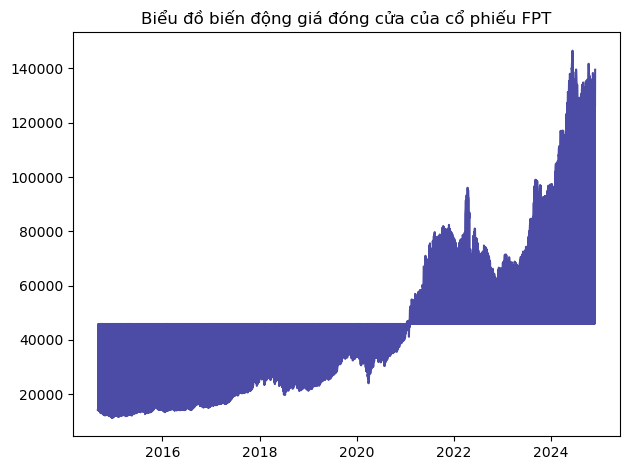

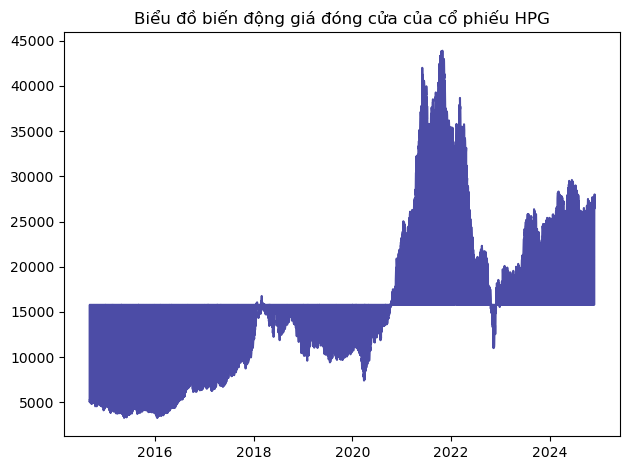

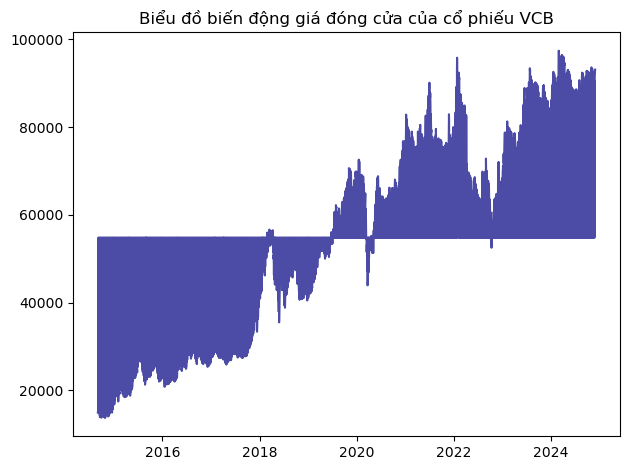

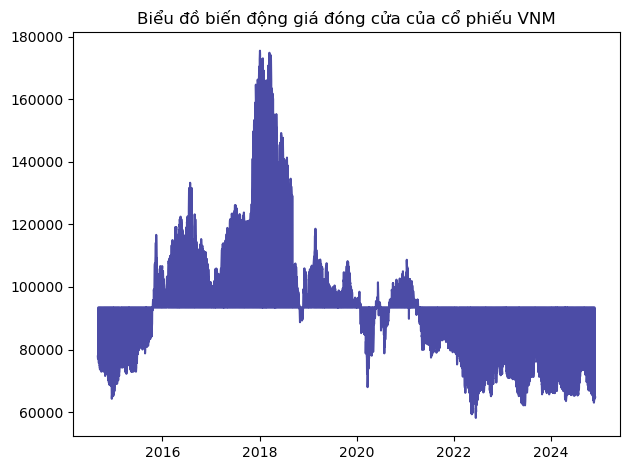

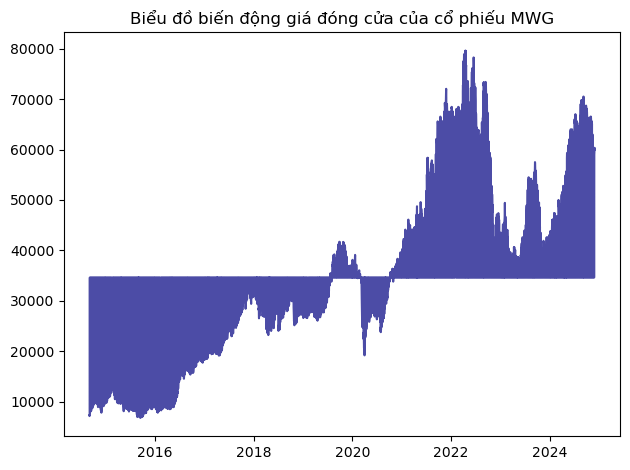

In [32]:
def price_change(key,value):
    plt.plot(value['Price'], label='Price', color='navy', alpha=0.7)
    plt.title(f"Biểu đồ biến động giá đóng cửa của cổ phiếu {key}")
    plt.tight_layout()
    plt.show()
for key,value in stock.items():
    price_change(key,value)

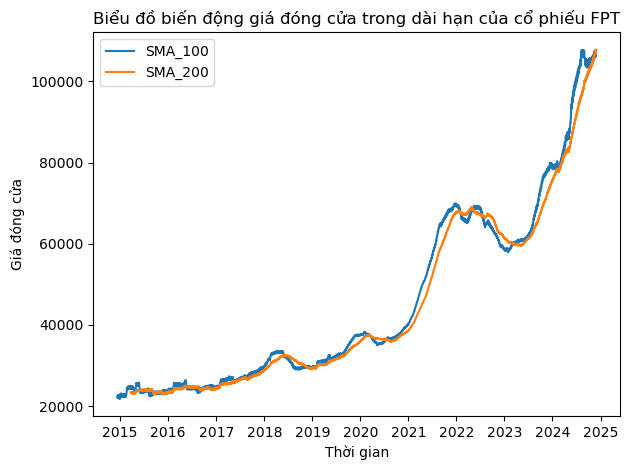

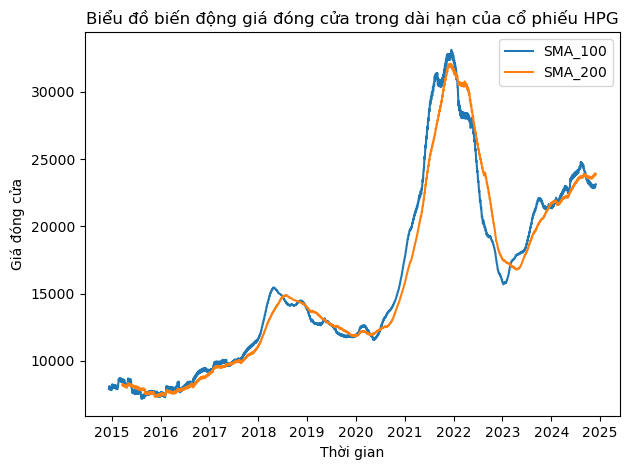

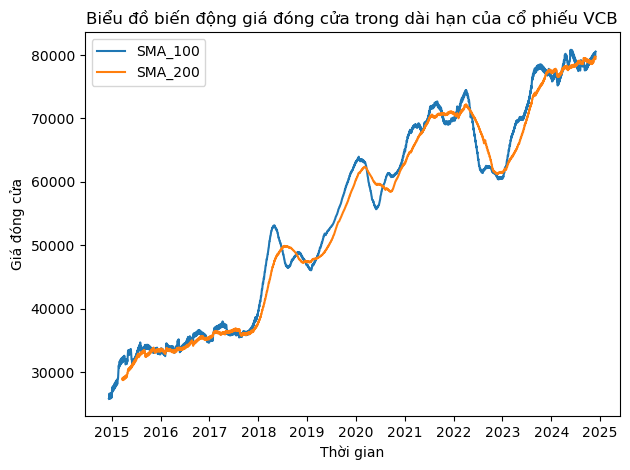

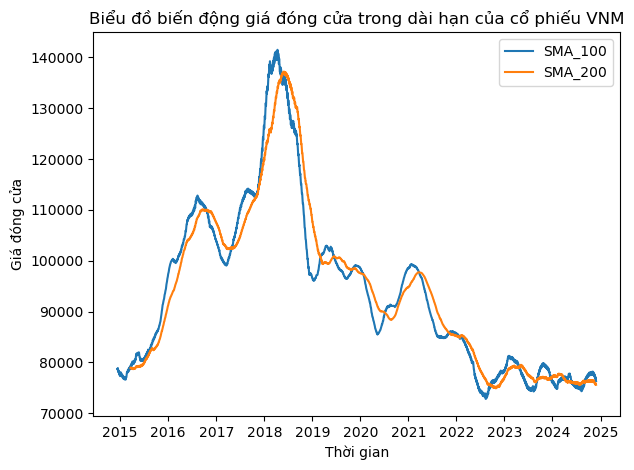

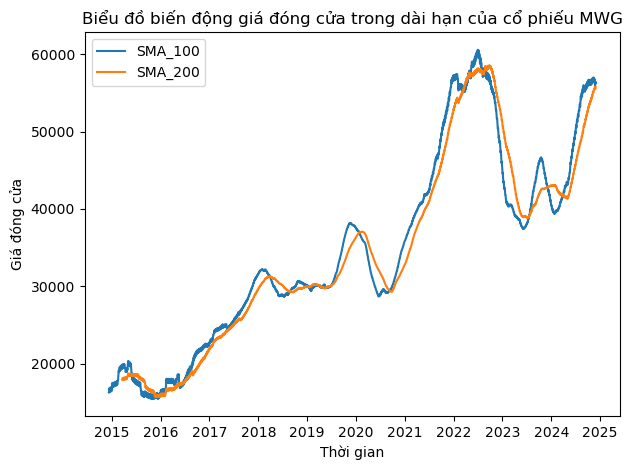

In [33]:
def MA_price_change(key,value):
    for i in [100,200]:
        plt.plot(value['Price'].rolling(window=i).mean(), label=f"SMA_{i}")
    plt.title(f"Biểu đồ biến động giá đóng cửa trong dài hạn của cổ phiếu {key}")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa')
    plt.tight_layout()
    plt.legend()
    plt.show()
for key,value in stock.items():      
    MA_price_change(key,value)

1. **Cổ phiếu FPT**:
   - Giá đóng cửa tăng trưởng ổn định trong dài hạn, đặc biệt rõ ràng từ năm 2020 đến 2024.
   - SMA 100 nằm sát SMA 200, phản ánh xu hướng dài hạn tích cực và ổn định.
   - Giai đoạn cuối năm 2023 và đầu năm 2024 có xu hướng tăng mạnh.

2. **Cổ phiếu HPG**:
   - Giá tăng mạnh từ năm 2020 đến 2021, đạt đỉnh vào khoảng cuối 2021 đến đầu năm 2022.
   - SMA 100 cắt xuống SMA 200 vào các giai đoạn giảm giá.
   - Xu hướng hiện tại cho thấy sự ổn định nhưng chưa có tín hiệu tăng mạnh.

3. **Cổ phiếu VCB**:
   - Giá tăng trưởng đều đặn trong dài hạn, với ít giai đoạn giảm mạnh.
   - SMA 100 luôn duy trì trên SMA 200, cho thấy xu hướng dài hạn tích cực và ổn định.
   - Giai đoạn gần đây tiếp tục cho thấy sự ổn định và khả năng tăng trưởng.

4. **Cổ phiếu VNM**:
   - Giá đóng cửa có sự biến động lớn, với đỉnh cao vào khoảng năm 2018 và suy giảm sau đó.
   - Sau năm 2021, giá có xu hướng đi ngang hoặc giảm nhẹ.
   - SMA 100 và SMA 200 giao cắt thường xuyên, cho thấy xu hướng không ổn định.

5. **Cổ phiếu MWG**:
   - Giá tăng trưởng mạnh từ năm 2015 đến đầu năm 2022, đạt đỉnh vào cuối năm 2022.
   - Xu hướng phục hồi vào năm 2023, nhưng giá vẫn chưa đạt lại đỉnh cũ.
   - SMA 100 và SMA 200 thể hiện xu hướng khá đồng nhất, tuy nhiên có các giai đoạn giao cắt, phản ánh sự biến động.

### Tổng quát:
- Các cổ phiếu FPT và VCB có xu hướng tăng trưởng ổn định và bền vững.
- Cổ phiếu VNM và HPG thể hiện sự biến động lớn và cần theo dõi kỹ để nhận định xu hướng.
- Cổ phiếu MWG cho thấy khả năng phục hồi nhưng cần thêm thời gian để quay lại đỉnh cũ.

## 3. Biến động khối lượng giao dịch của các cổ phiếu

Cổ phiếu FPT


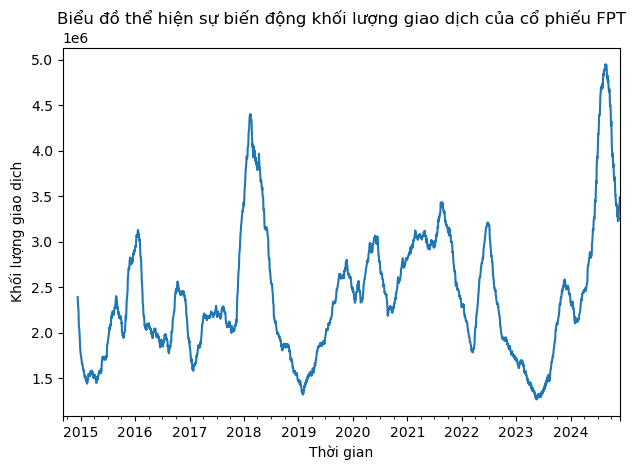

Cổ phiếu HPG


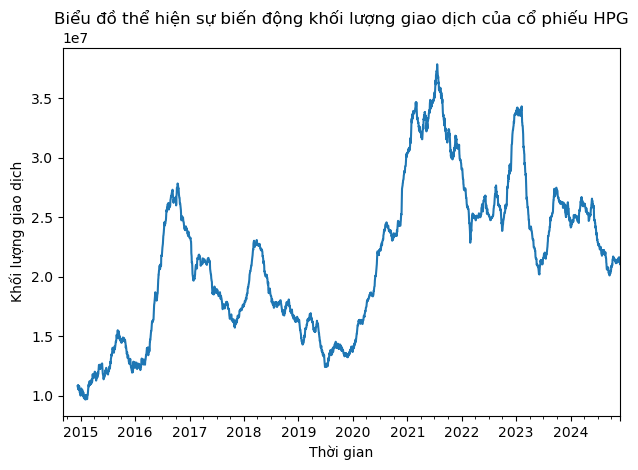

Cổ phiếu VCB


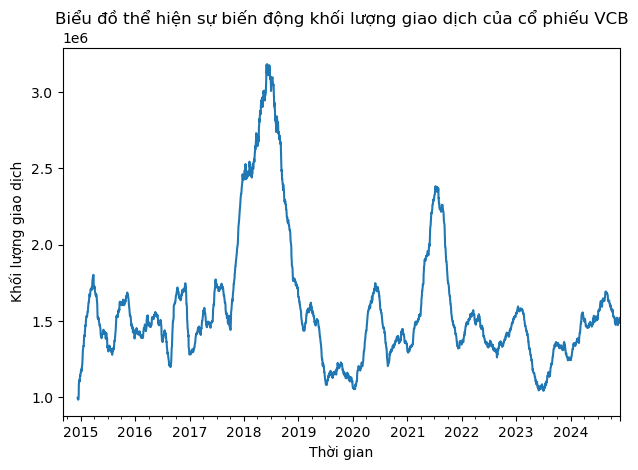

Cổ phiếu VNM


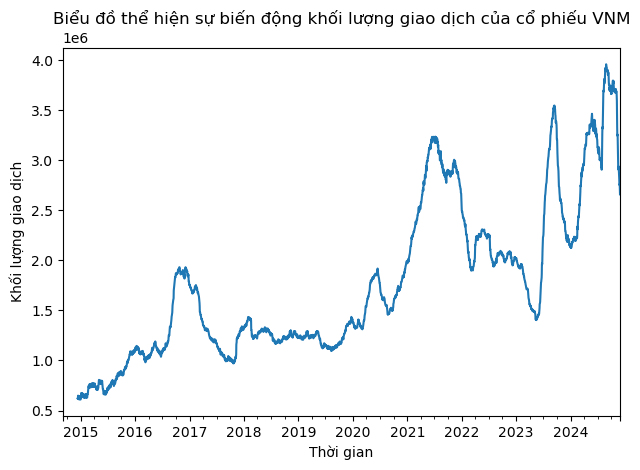

Cổ phiếu MWG


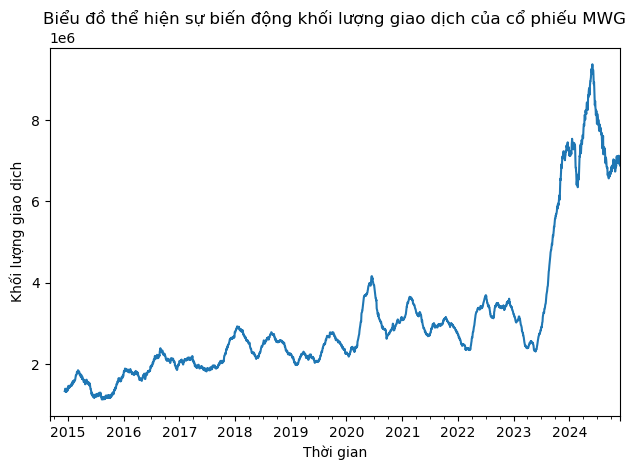

In [36]:
for key, item in stock.items():
    print(f"Cổ phiếu {key}")
    item['Vol.'].rolling(window=100).mean().plot(kind='line')
    plt.title(f"Biểu đồ thể hiện sự biến động khối lượng giao dịch của cổ phiếu {key}")
    plt.xlabel('Thời gian')
    plt.ylabel('Khối lượng giao dịch')
    plt.tight_layout()
    plt.show()

1. **Cổ phiếu FPT**
- **Xu hướng khối lượng giao dịch**:
  - Giao dịch dao động ở mức trung bình (1.5-3.5 triệu cổ phiếu/ngày).
  - Khối lượng giao dịch đạt đỉnh 2 lần lần lượt ở khoảng năm 2018 với khoảng 4.5 triệu cổ phiếu/ngày và cuối năm 2024 với khoảng 5 triệu cổ phiếu/ngày.
  - Giai đoạn từ 2020, khối lượng giao dịch trung bình cao hơn so với giai đoạn trước năm 2020.
- **Nhận xét**:
  - Sự gia tăng khối lượng giao dịch từ 2020 có thể phản ánh sự tăng trưởng của doanh nghiệp trong lĩnh vực công nghệ.
  - Khối lượng giao dịch ổn định hơn so với HPG hay MWG, cho thấy đây là cổ phiếu có sự tin cậy từ nhà đầu tư dài hạn.

2. **Cổ phiếu HPG**
- **Xu hướng khối lượng giao dịch**:
  - Khối lượng giao dịch trung bình nhiều nhất trong cả 5 cổ phiếu
  - Khối lượng tăng trưởng mạnh từ năm 2015 đến 2021, đạt đỉnh cao vào cuối năm 2021 với hơn 35 triệu cổ phiếu/ngày.
  - Sau năm 2021, khối lượng giảm nhưng vẫn duy trì ở mức cao (trên 10 triệu cổ phiếu/ngày).
- **Nhận xét**:
  - HPG là cổ phiếu có tính thanh khoản cao, với khối lượng giao dịch lớn nhất trong 5 cổ phiếu.
  - Đỉnh khối lượng năm 2021 trùng với giai đoạn giá cổ phiếu tăng mạnh, cho thấy sự quan tâm lớn của nhà đầu tư trong giai đoạn này.

3. **Cổ phiếu VCB**
- **Xu hướng khối lượng giao dịch**:
  - Giai đoạn 2015-2017: Khối lượng giao dịch ổn định ở mức thấp (khoảng 1-1.5 triệu cổ phiếu/ngày).
  - Khối lượng giao dịch đạt đỉnh năm 2018 với khối lượng tăng mạnh (hơn 3 triệu cổ phiếu/ngày), sau đó giảm trở lại và duy trì mức thấp hơn từ năm 2019 đến 2024.
- **Nhận xét**:
  - Khối lượng giao dịch của VCB không có sự tăng trưởng đều như giá cổ phiếu, cho thấy đây là một cổ phiếu an toàn, thường được nhà đầu tư dài hạn nắm giữ, ít biến động.

4. **Cổ phiếu VNM**
- **Xu hướng khối lượng giao dịch**:
  - Giai đoạn 2016-2020: Giao dịch tương đối ổn định, khối lượng dao động quanh mức 1-2 triệu cổ phiếu/ngày.
  - Giai đoạn 2020-2024: Khối lượng tăng đáng kể, đạt đỉnh vào nửa cuối năm 2021, đầu năm 2022 với hơn 3 triệu cổ phiếu/ngày và nửa cuối năm 2024 với 4 triệu cổ phiếu/ngày.
- **Nhận xét**:
  - Sự tăng khối lượng giao dịch vào các năm 2021 và 2023 có thể do nhà đầu tư kỳ vọng vào sự phục hồi hoặc tái cấu trúc của doanh nghiệp, đặc biệt có thể đến từ việc công ty đổi bao bì sản phẩm khiến cho doanh số tăng, từ đó tạo được niềm tin nơi nhà đầu tư.
  - Tuy nhiên, khối lượng giao dịch không ổn định, cho thấy tâm lý nhà đầu tư có phần dao động.

5. **Cổ phiếu MWG**
- **Xu hướng khối lượng giao dịch**:
  - Khối lượng giao dịch tương đối thấp trong giai đoạn 2015-2019 (2-4 triệu cổ phiếu/ngày).
  - Bắt đầu tăng mạnh từ năm 2020 và đạt đỉnh vào năm 2024 với hơn 8 triệu cổ phiếu/ngày.
  - Sau đó, khối lượng giảm nhẹ nhưng vẫn cao hơn nhiều so với giai đoạn trước 2020.
- **Nhận xét**:
  - Sự tăng khối lượng từ năm 2020 có thể phản ánh sự mở rộng của doanh nghiệp hoặc sự quan tâm từ nhà đầu tư trong bối cảnh kinh tế thuận lợi.
  - Tuy nhiên, việc khối lượng giảm từ 2022 cho thấy nhà đầu tư có phần thận trọng hơn.

### **Nhận xét tổng quát**
1. **Cổ phiếu thanh khoản cao**:
   - **HPG** và **MWG** có khối lượng giao dịch lớn, thể hiện tính thanh khoản cao và sự hấp dẫn đối với nhà đầu tư ngắn hạn.
   - Đặc biệt, **HPG** có khối lượng giao dịch vượt trội, phù hợp với nhà đầu tư yêu thích sự sôi động.

2. **Cổ phiếu giao dịch ổn định**:
   - **VCB**, **VNM**, và **FPT** có khối lượng giao dịch thấp hơn, ổn định hơn, phản ánh sự phù hợp với nhà đầu tư dài hạn.

3. **Tâm lý nhà đầu tư**:
   - Các đỉnh cao về khối lượng giao dịch thường đi kèm với những giai đoạn tăng giá hoặc kỳ vọng tích cực từ thị trường.
   - Sau những giai đoạn đỉnh cao, khối lượng giao dịch giảm có thể phản ánh sự điều chỉnh tâm lý của nhà đầu tư.

## 4. Biến động về lợi nhuận hàng ngày các cổ phiếu mang lại

Cổ phiếu FPT


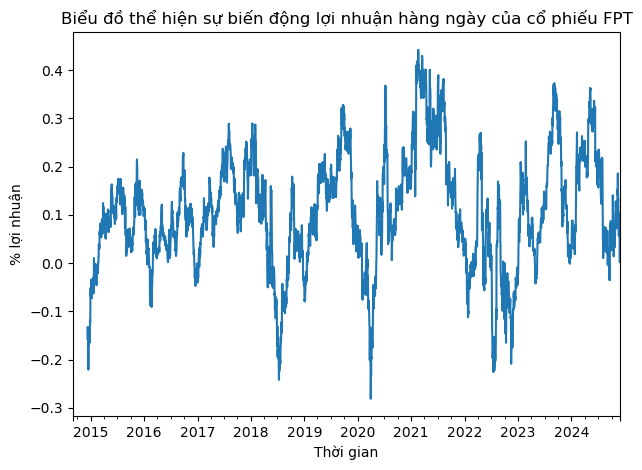

Cổ phiếu HPG


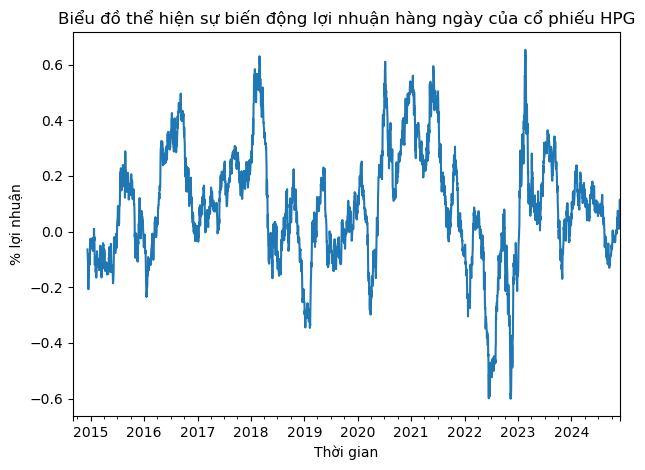

Cổ phiếu VCB


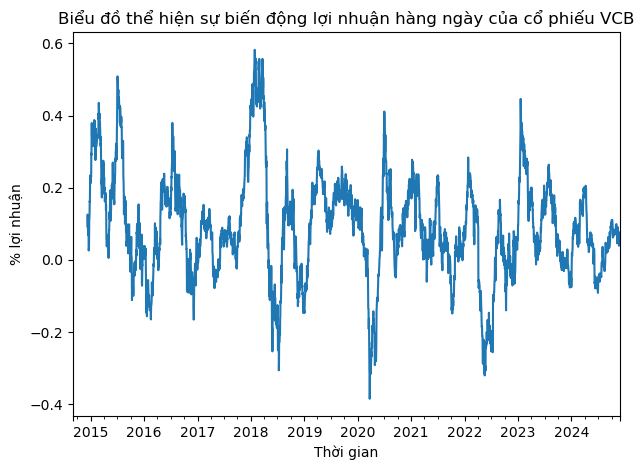

Cổ phiếu VNM


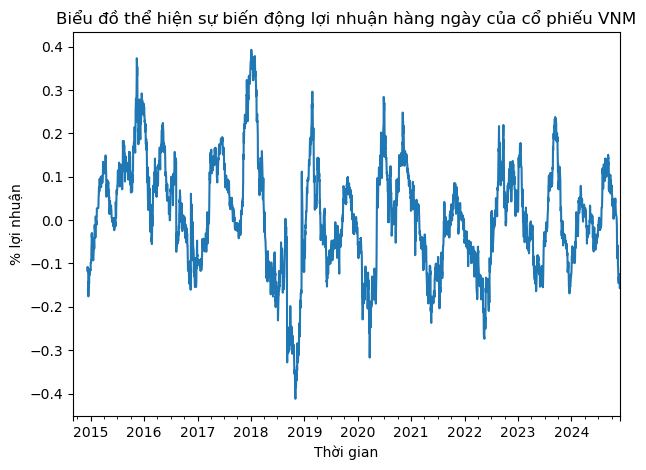

Cổ phiếu MWG


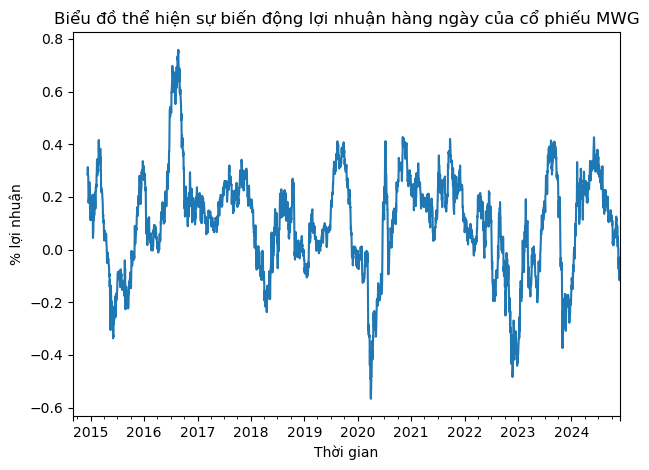

In [39]:
for key, item in stock.items():
    print(f"Cổ phiếu {key}")
    item['Change %'].rolling(window=100).mean().plot(kind='line')
    plt.title(f"Biểu đồ thể hiện sự biến động lợi nhuận hàng ngày của cổ phiếu {key}")
    plt.xlabel('Thời gian')
    plt.ylabel('% lợi nhuận')
    plt.tight_layout()
    plt.show()

Lợi nhuận hàng ngày của các cổ phiếu được tính bằng phần trăm chênh lệch giá đóng cửa của các cổ phiếu mỗi ngày.
1. **Cổ phiếu FPT**
- **Biến động**:
  - Dao động trong khoảng từ -0.3% đến 0.4%.
  - Tương đối ổn định, với ít giai đoạn biến động bất thường.
- **Nhận xét**:
  - FPT là cổ phiếu ổn định với mức biến động thấp hơn HPG hay MWG, phù hợp với nhà đầu tư dài hạn và trung hạn.

2. **Cổ phiếu HPG**
- **Biến động**:
  - Lợi nhuận dao động rộng hơn, từ -0.6% đến 0.6%.
  - Có nhiều giai đoạn xuất hiện các đỉnh cao hoặc đáy sâu, đặc biệt trong các năm 2020-2021.
- **Nhận xét**:
  - HPG là cổ phiếu có độ rủi ro cao hơn do biên độ dao động lớn, phù hợp với nhà đầu tư chấp nhận rủi ro để tìm kiếm cơ hội lợi nhuận lớn.

3. **Cổ phiếu VCB**
- **Biến động**:
  - Lợi nhuận dao động trong khoảng từ -0.4% đến 0.4% trong suốt giai đoạn.
  - Biến động khá ổn định, không xuất hiện các đợt dao động mạnh bất thường.
- **Nhận xét**:
  - Lợi nhuận hàng ngày của VCB ít biến động, cho thấy đây là cổ phiếu tương đối ổn định và an toàn, phù hợp với nhà đầu tư có khẩu vị rủi ro thấp.

4. **Cổ phiếu VNM**
- **Biến động**:
  - Biên độ dao động nhỏ hơn, từ -0.4% đến 0.4%.
  - Không xuất hiện các giai đoạn biến động đột ngột hay bất thường.
- **Nhận xét**:
  - Cổ phiếu VNM cũng là một lựa chọn ổn định, với lợi nhuận hàng ngày ít biến động. Điều này phù hợp với danh tiếng của VNM là cổ phiếu phòng thủ.

5. **Cổ phiếu MWG**
- **Biến động**:
  - Lợi nhuận dao động mạnh nhất trong số các cổ phiếu, từ -0.6% đến 0.8%.
  - Có nhiều đợt biến động mạnh, lợi nhuận âm nhiều, đặc biệt trong các năm 2020 và 2023.
- **Nhận xét**:
  - MWG là cổ phiếu mang tính chu kỳ và phản ứng mạnh với các yếu tố thị trường, do đó lợi nhuận hàng ngày biến động lớn, phù hợp với nhà đầu tư ngắn hạn.

### **Nhận xét tổng quan**
1. **Cổ phiếu ổn định**:
   - **VCB, VNM, và FPT** có biên độ dao động lợi nhuận hàng ngày thấp, phù hợp với nhà đầu tư ưu tiên sự an toàn và ổn định.
2. **Cổ phiếu rủi ro cao hơn**:
   - **HPG và MWG** có mức biến động lợi nhuận hàng ngày lớn hơn, cho thấy rủi ro cao hơn nhưng cũng có cơ hội mang lại lợi nhuận lớn cho nhà đầu tư.
3. **Thời điểm biến động mạnh**:
   - Giai đoạn 2020-2021 chứng kiến nhiều biến động lớn (đỉnh và đáy) trên các cổ phiếu, có thể do ảnh hưởng từ các yếu tố kinh tế vĩ mô (như dịch COVID-19) và tâm lý thị trường.

# Feature Engineering

Trước tiên nhóm xem xét mối quan hệ giữa các feature có sẵn trong dataset

Cổ phiếu FPT


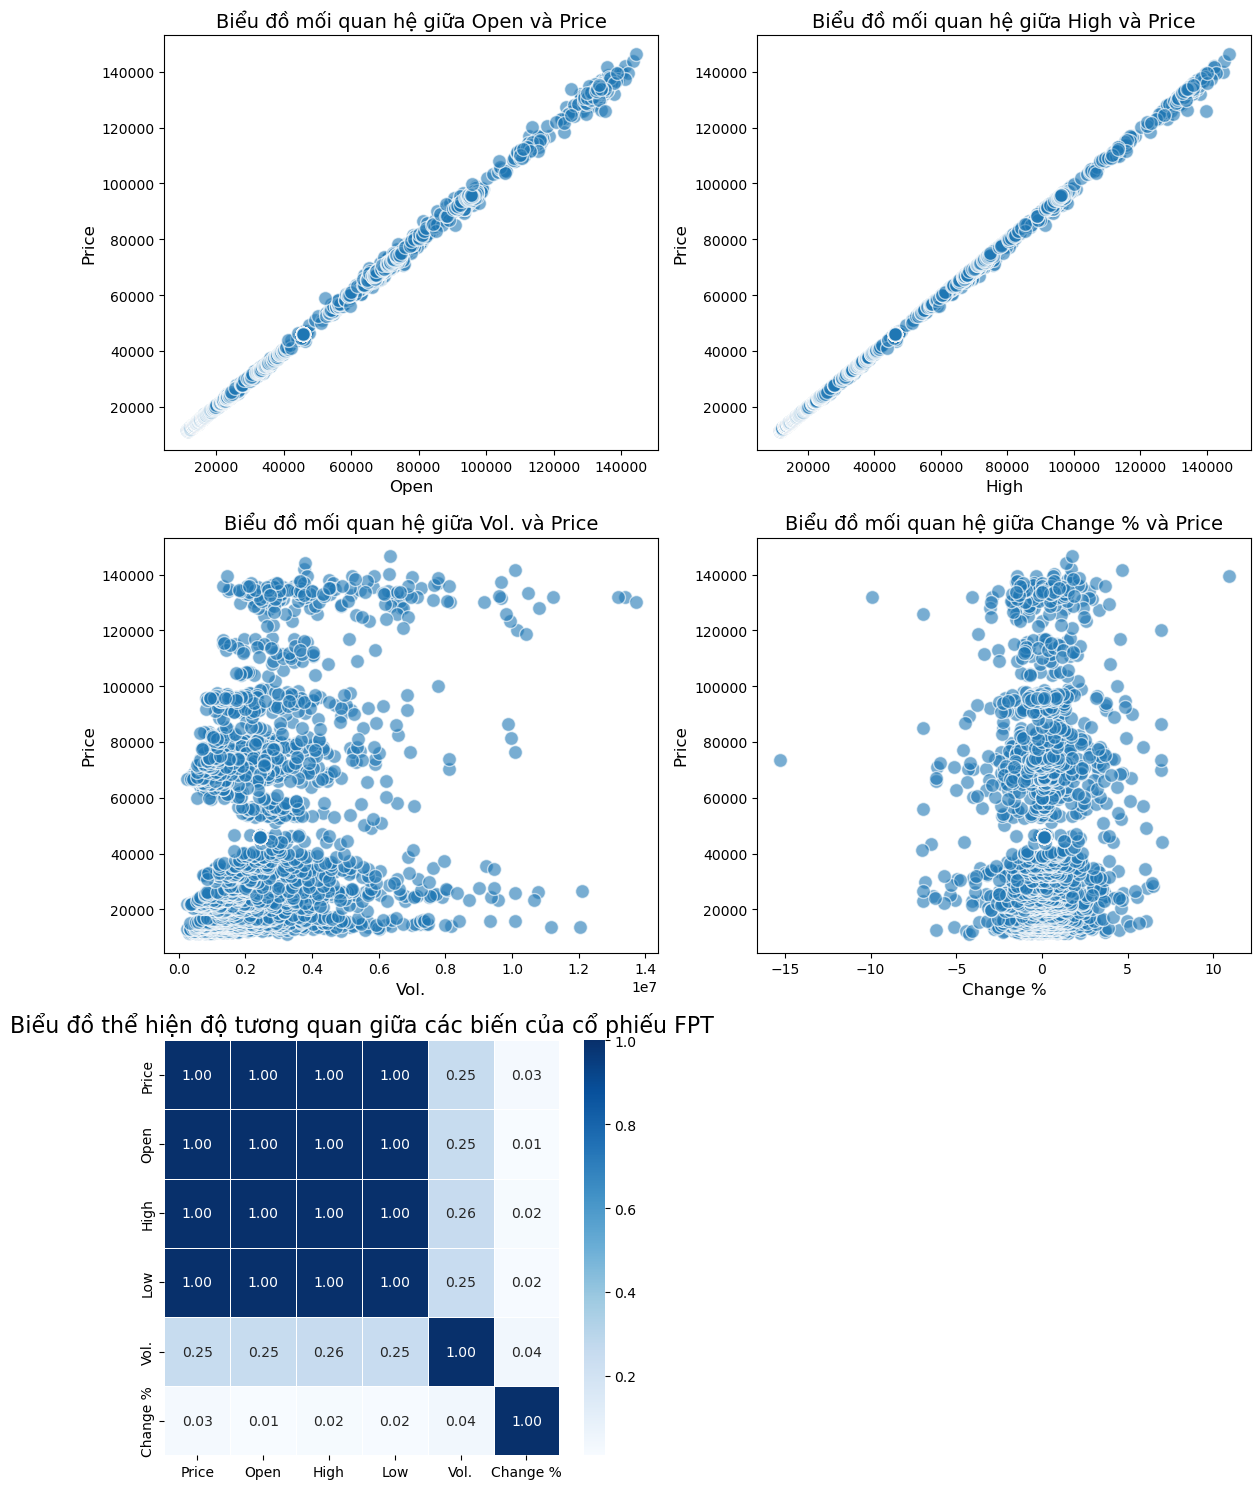

Cổ phiếu HPG


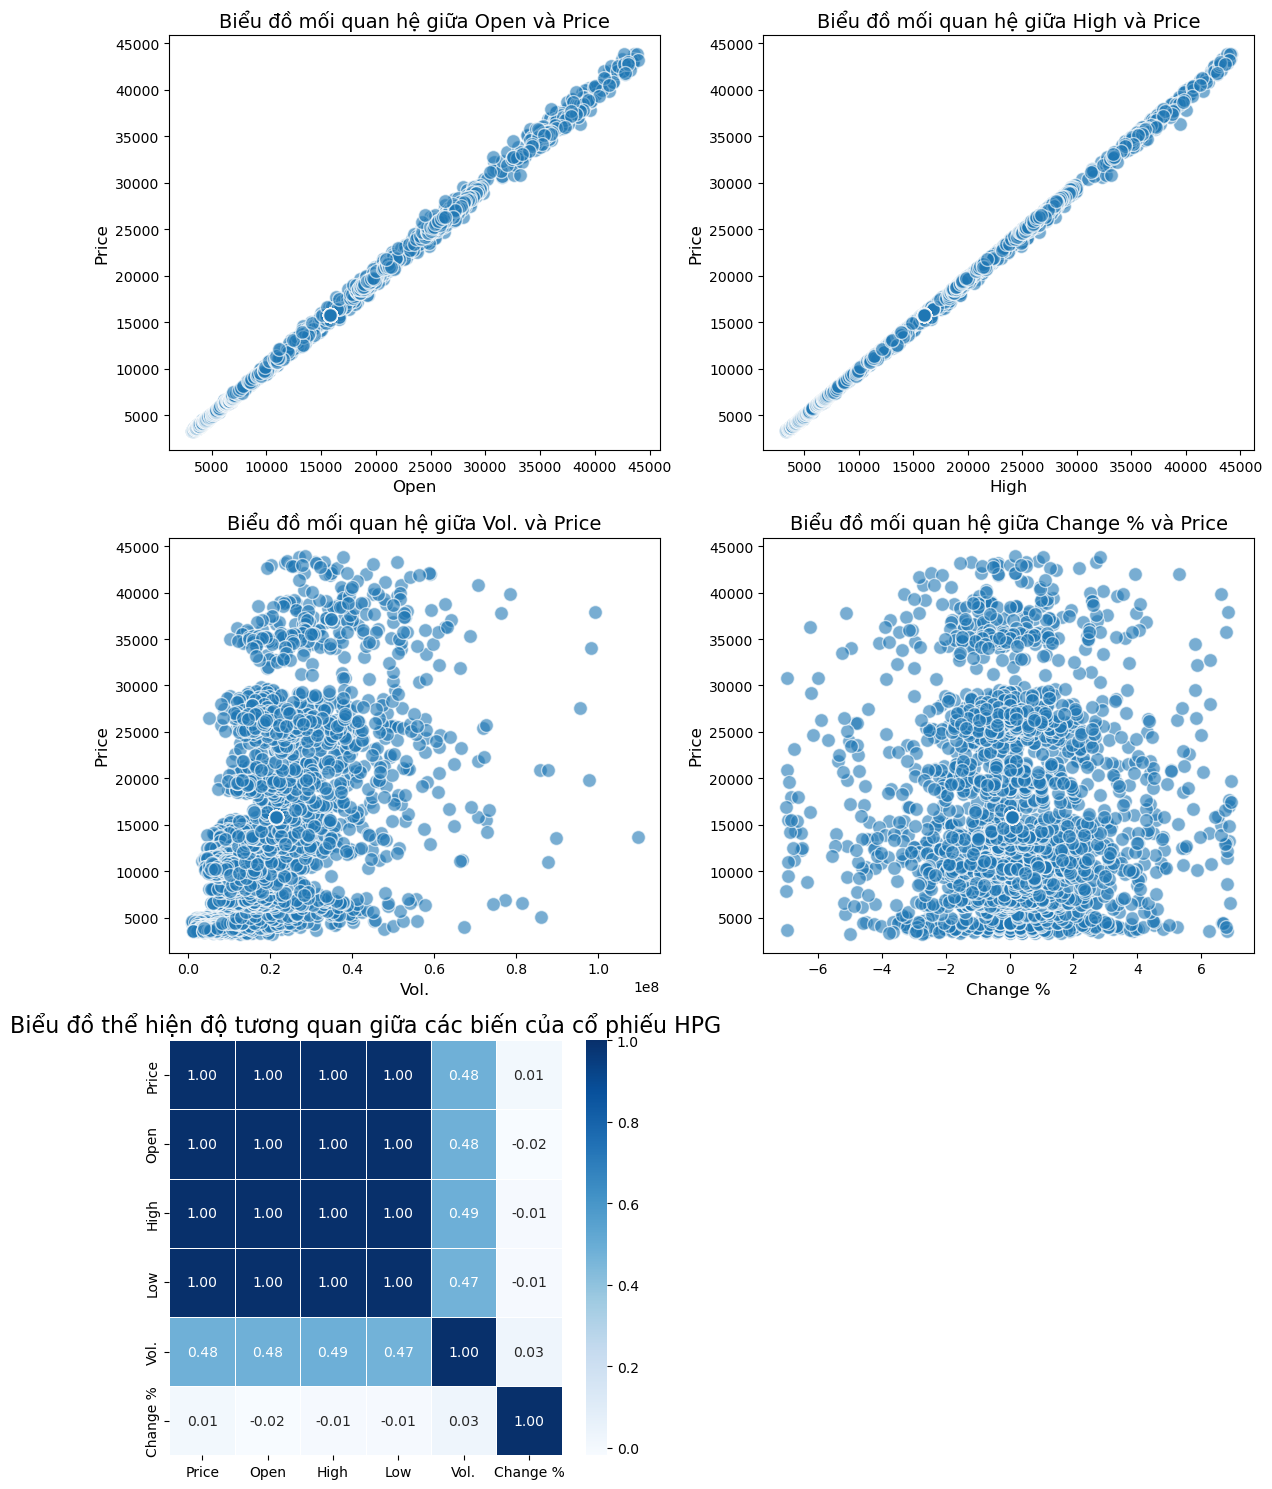

Cổ phiếu VCB


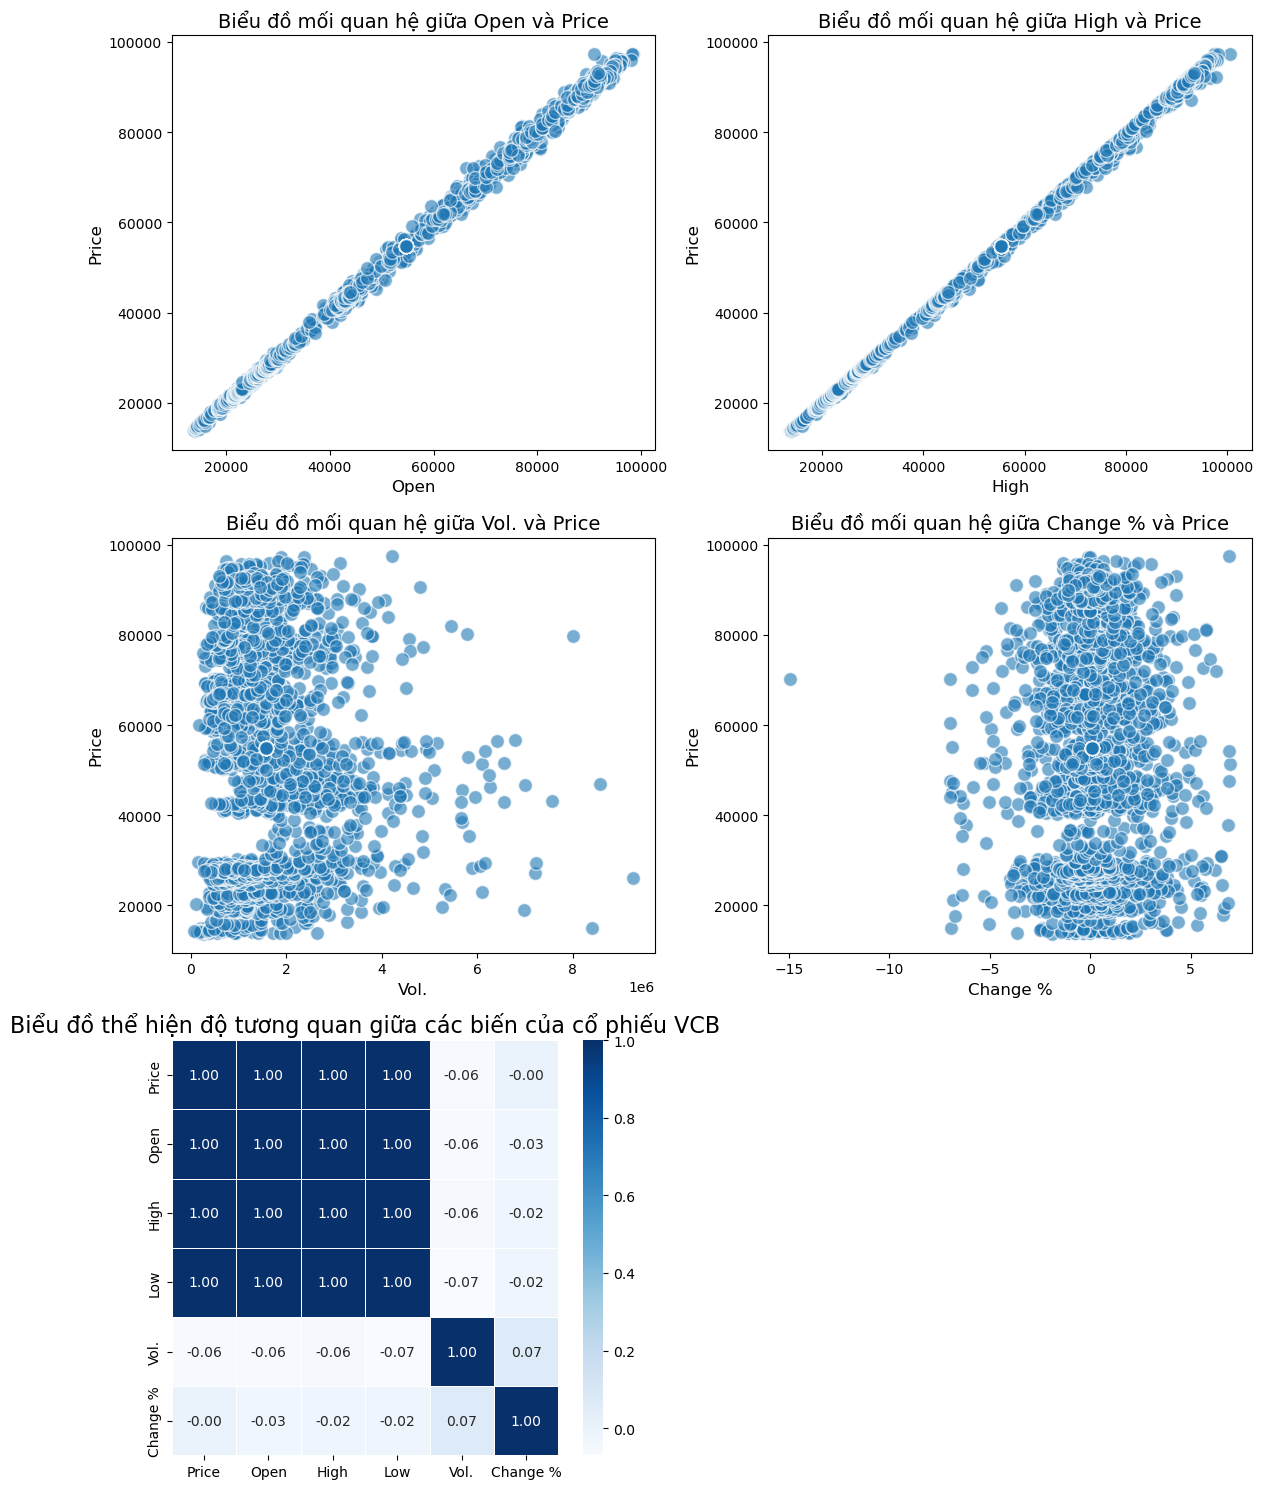

Cổ phiếu VNM


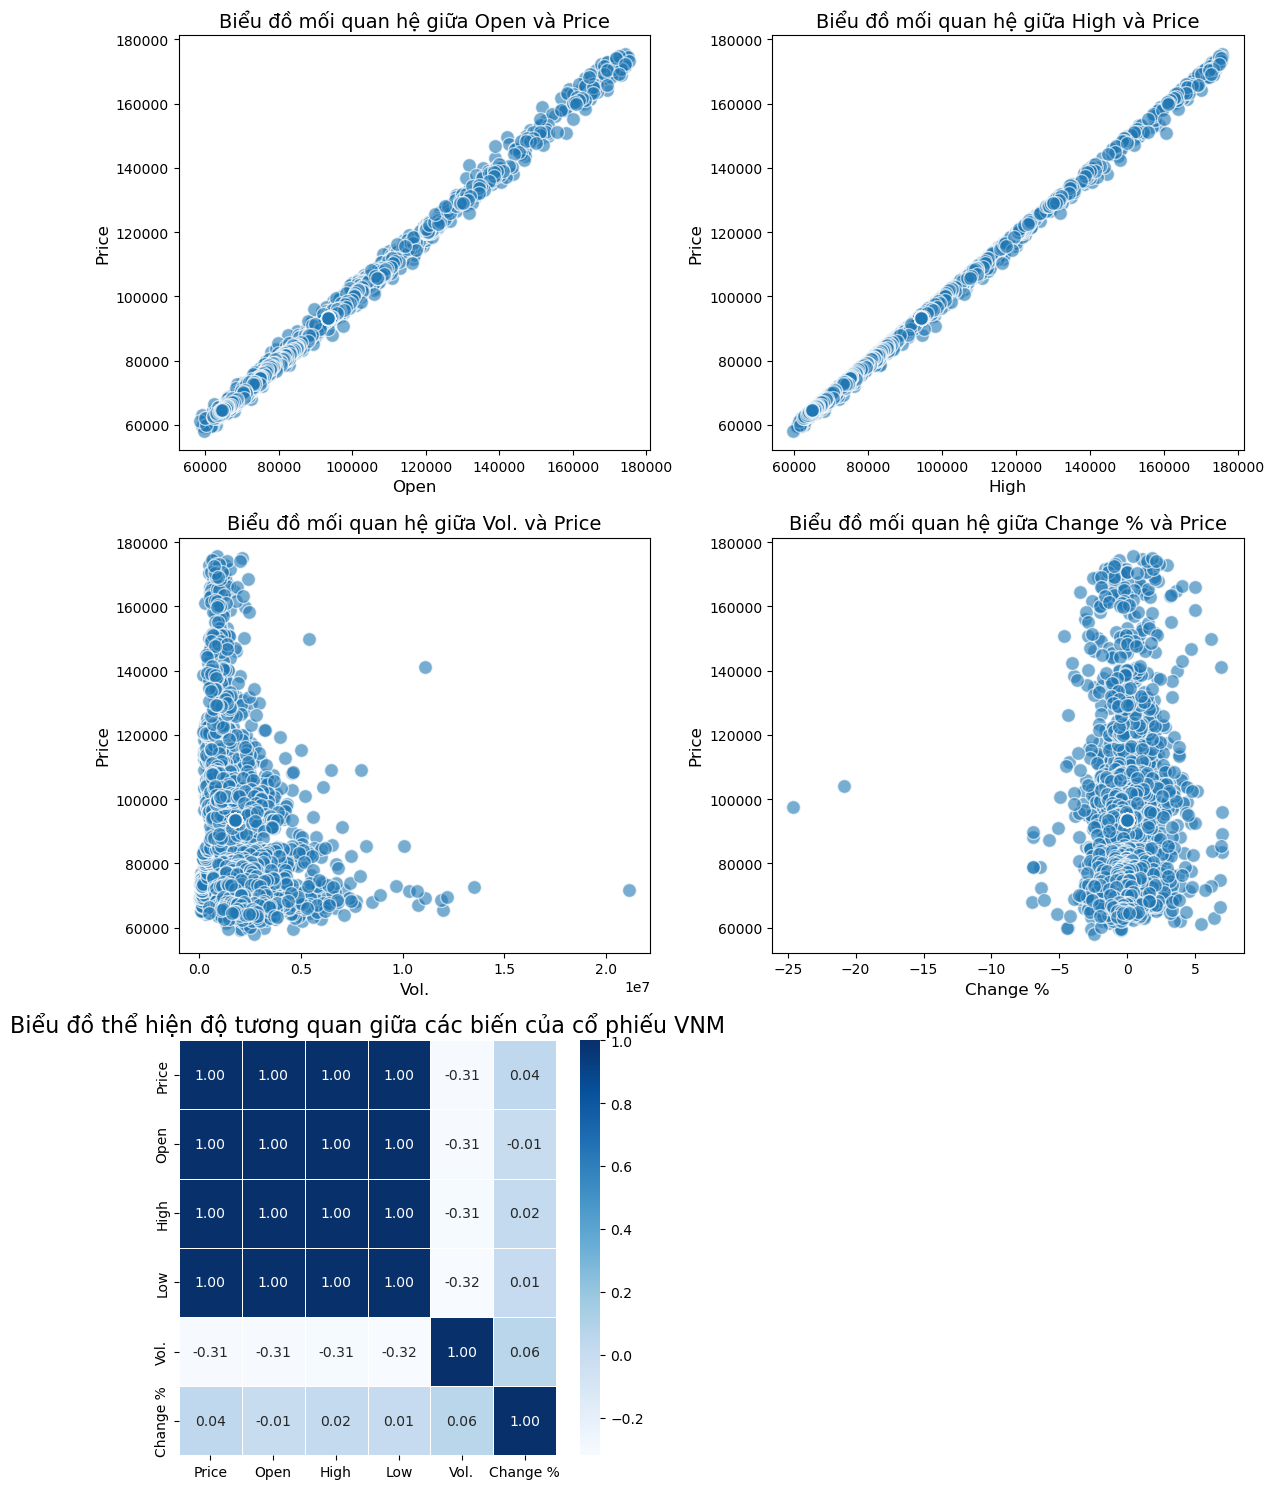

Cổ phiếu MWG


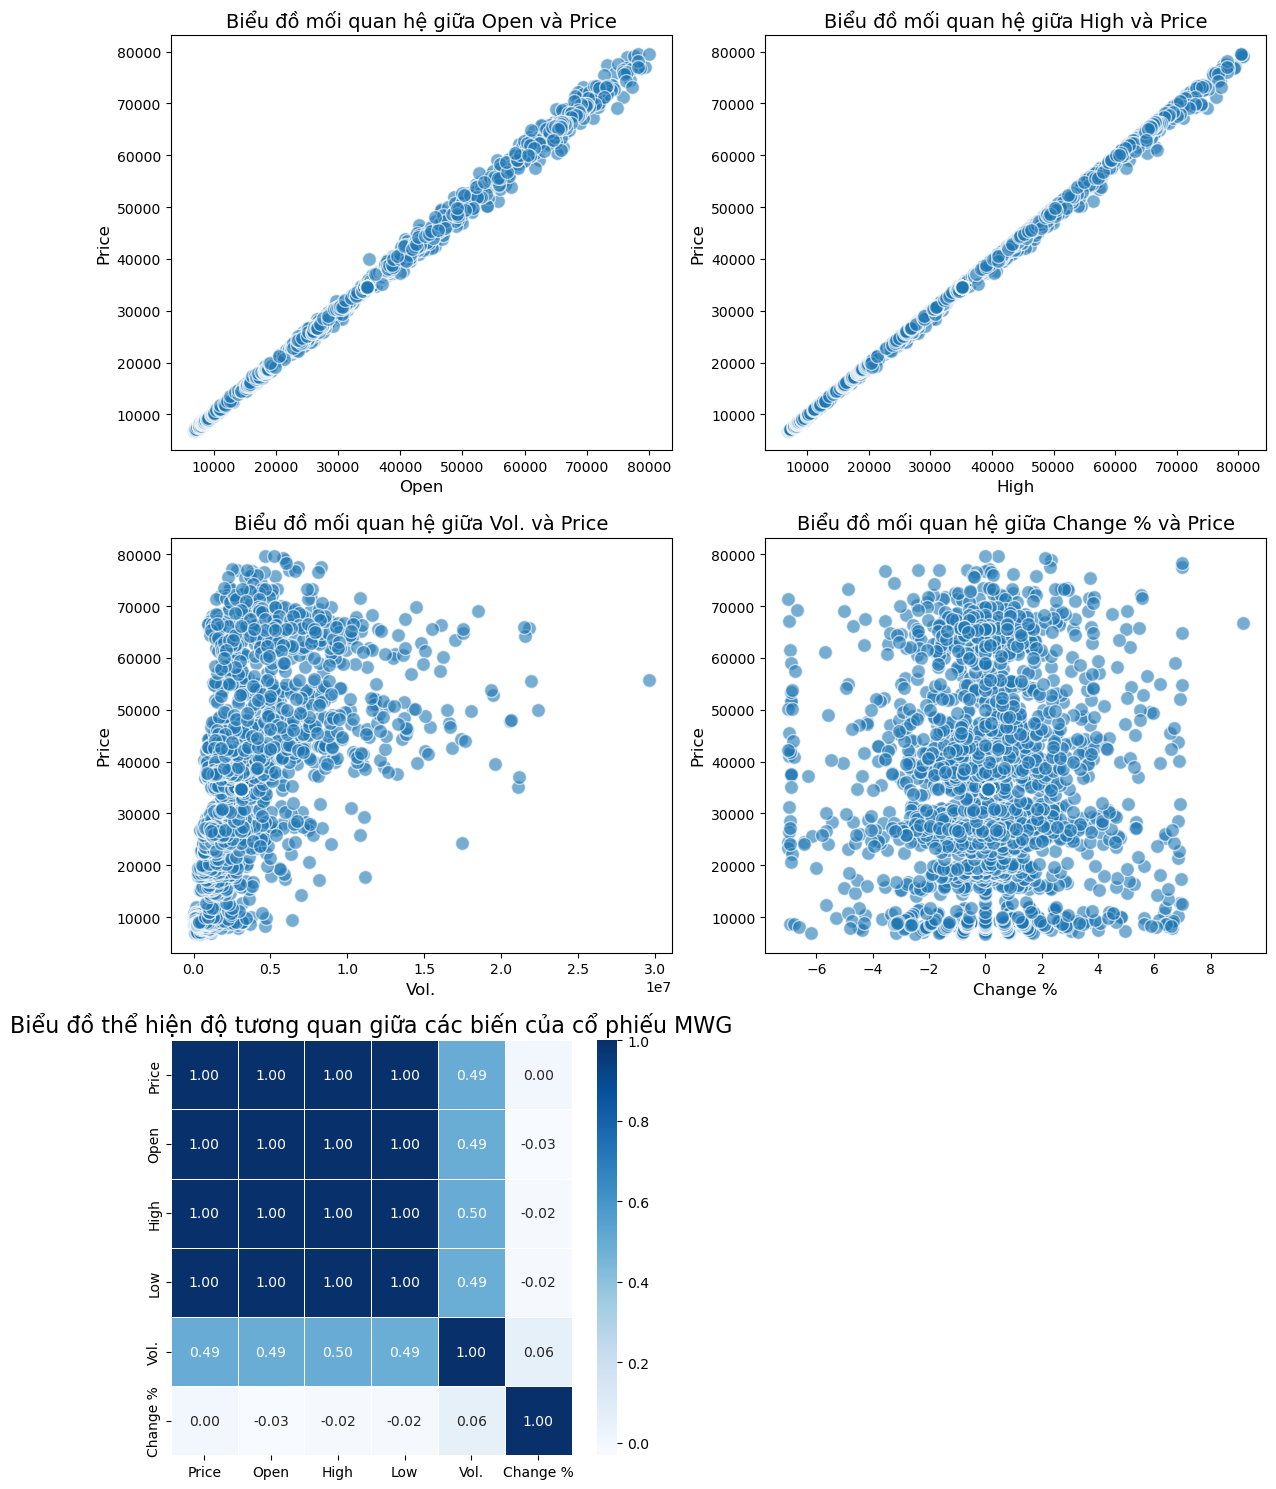

In [43]:
def relationship_plot(key, value):
    print(f"Cổ phiếu {key}")
    x_columns=['Open','High','Vol.','Change %']
    y_col='Price'
    # Tạo 1 ma trận 2x2 cho các scatter plots và 1 biểu đồ heatmap ở dưới cùng
    fig,axes=plt.subplots(3,2,figsize=(12, 15))  # 3 hàng: 2 scatter plots mỗi hàng + 1 hàng heatmap
    fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Điều chỉnh khoảng cách giữa các plot
    
    # Tạo scatter plots thể hiện mối quan hệ giữa các biến độc lập và biến phụ thuộc
    for i, col in enumerate(x_columns):
        i_row,i_col = divmod(i,2)  # Xác định chỉ số hàng và cột nơi đặt scatter plot
        axes[i_row, i_col].scatter(value[col], value[y_col], alpha=0.6, edgecolors='w', s=100)
        axes[i_row, i_col].set_title(f"Biểu đồ mối quan hệ giữa {col} và {y_col}", fontsize=14)
        axes[i_row, i_col].set_xlabel(col, fontsize=12)
        axes[i_row, i_col].set_ylabel(y_col, fontsize=12)
    
    # Tạo heatmap
    value_corr = value.corr()
    ax2 = axes[2,0]
    sns.heatmap(value_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, ax=ax2)
    ax2.set_title(f"Biểu đồ thể hiện độ tương quan giữa các biến của cổ phiếu {key}", fontsize=16)
    # Tắt ô đồ thị không dùng đến
    axes[2, 1].axis('off')
    plt.tight_layout()
    plt.show()

for key, value in stock.items():
    relationship_plot(key, value)

Từ các biểu đồ trên, có thể thấy ở cả 5 cổ phiếu, biến `Vol.` và `Change %` đều không có sự tương quan đáng kể đến biến phụ thuộc là `Price` nên chúng hoàn toàn có thể bị loại bỏ

In [45]:
for key,value in stock.items():
    stock[key].drop(columns=['Vol.','Change %'],inplace=True)
    print(f"Cổ phiếu {key}")
    print(stock[key].head())

Cổ phiếu FPT
               Price      Open      High       Low
Date                                              
2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30
2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30
2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20
2014-09-06 45,896.54 45,881.92 46,385.08 45,404.60
2014-09-07 45,896.54 45,881.92 46,385.08 45,404.60
Cổ phiếu HPG
               Price      Open      High       Low
Date                                              
2014-09-03  5,126.40  5,040.30  5,126.40  5,040.30
2014-09-04  5,255.70  5,126.40  5,341.80  5,126.40
2014-09-05  5,255.70  5,212.60  5,255.70  5,169.50
2014-09-06 15,792.35 15,797.75 16,010.80 15,592.51
2014-09-07 15,792.35 15,797.75 16,010.80 15,592.51
Cổ phiếu VCB
               Price      Open      High       Low
Date                                              
2014-09-03 14,923.00 14,765.00 15,029.00 14,765.00
2014-09-04 15,187.00 14,818.00 15,187.00 14,660.00
2014-09-05 15,451.00 15,187.00 15,503.00 15

Tiếp theo cần kiểm tra xem giá cổ phiếu ở hiện tại có độ tương quan nhất định nào với chính nó ở quá khứ không. Nói cách khác, cần tìm hiểu xem giá cổ phiếu ở quá khứ có tác động gì về mặt thống kê với giá cổ phiếu ở hiện tại không

Cổ phiếu FPT


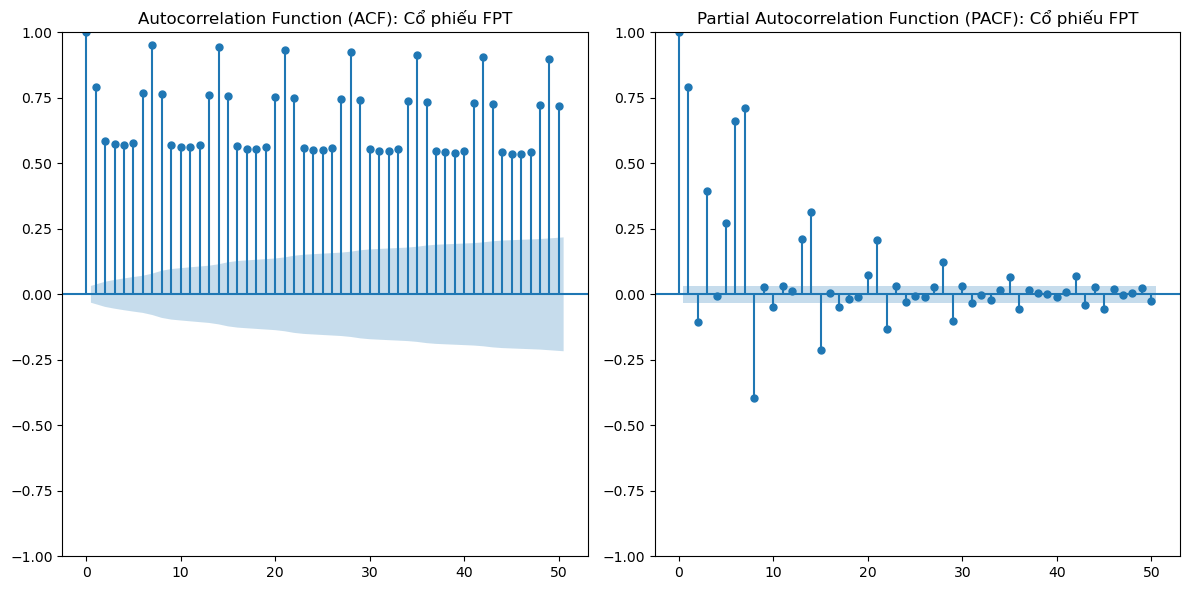

Cổ phiếu HPG


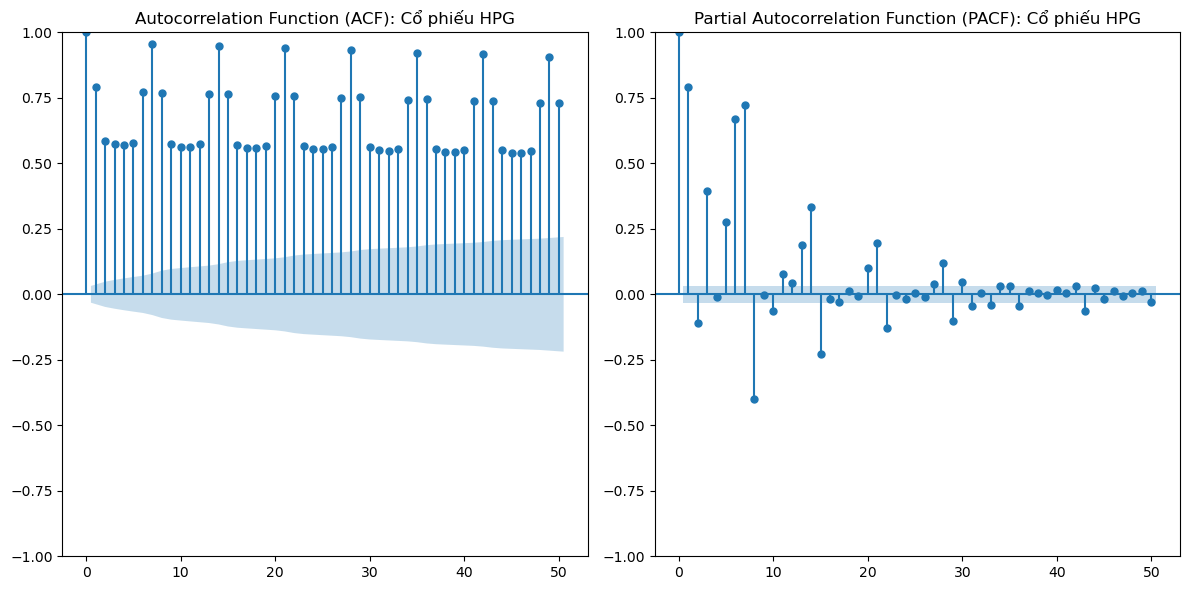

Cổ phiếu VCB


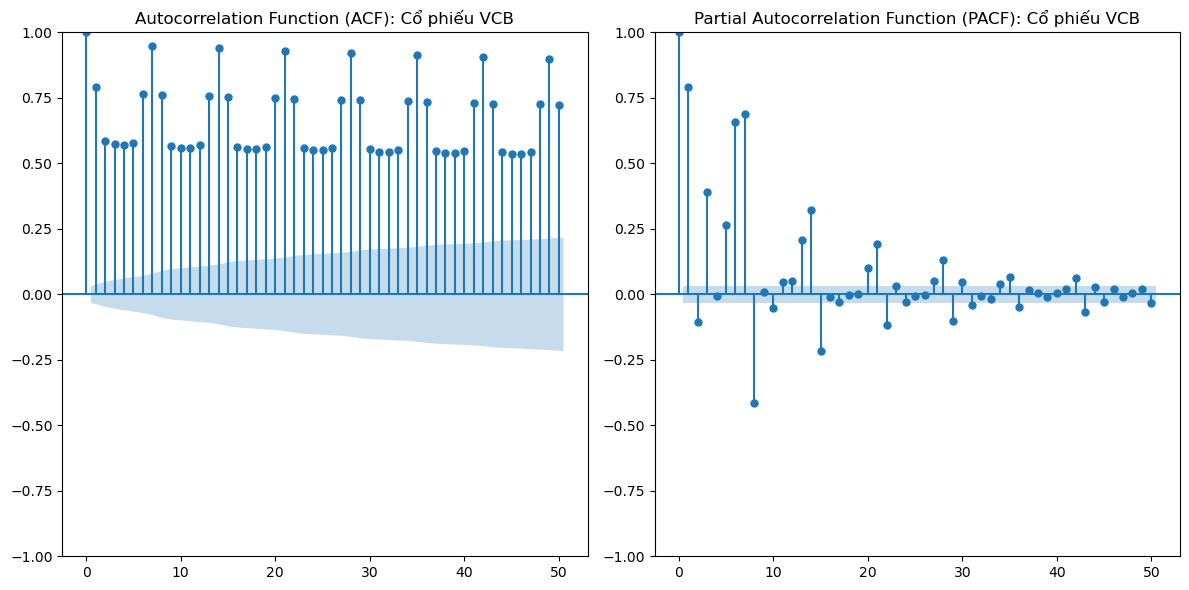

Cổ phiếu VNM


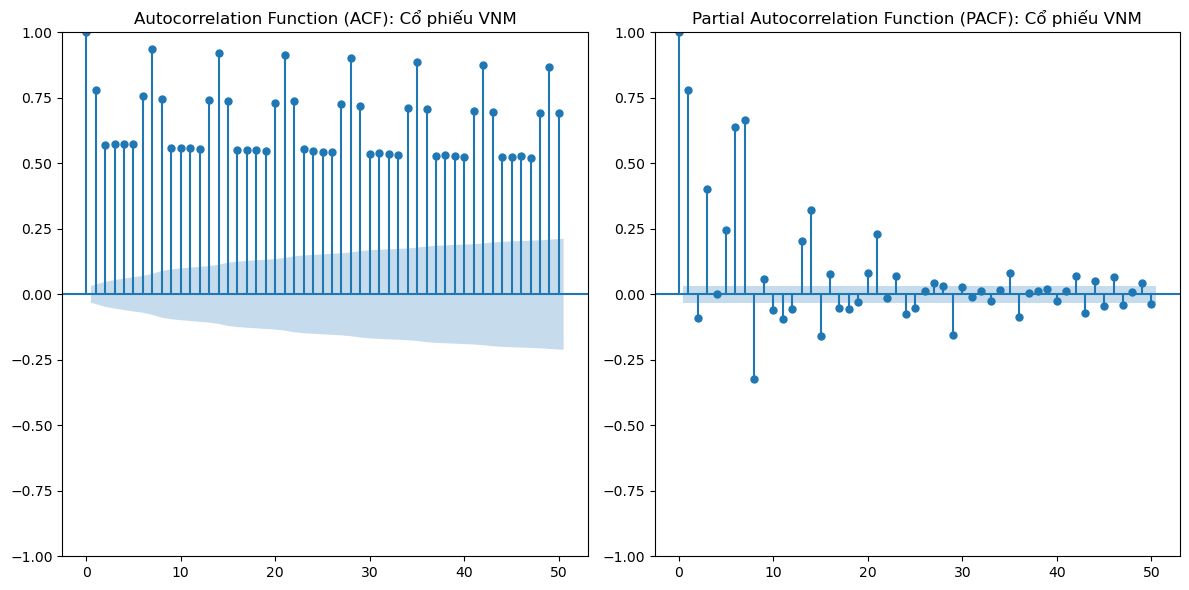

Cổ phiếu MWG


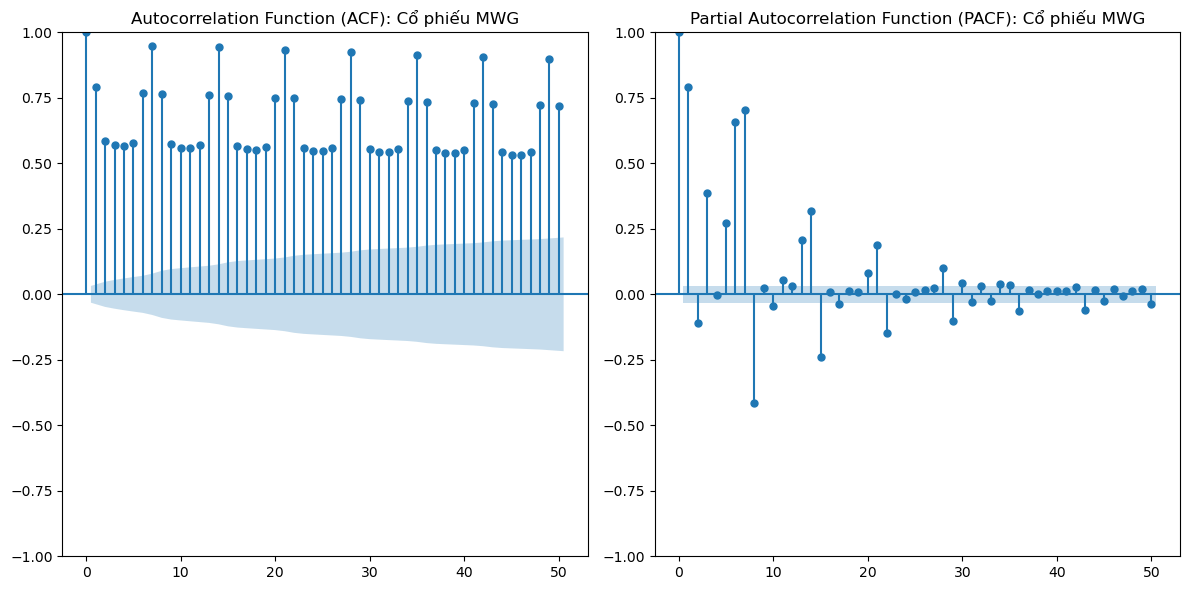

In [47]:
def acf_pacf(key,value,n_lags):
    print(f"Cổ phiếu {key}")
    price = value['Price']
    # Vẽ ACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(price, ax=plt.gca(), lags=n_lags)
    plt.title(f'Autocorrelation Function (ACF): Cổ phiếu {key}')
    # Vẽ PACF
    plt.subplot(122)
    plot_pacf(price, ax=plt.gca(), lags=n_lags)
    plt.title(f'Partial Autocorrelation Function (PACF): Cổ phiếu {key}')
    plt.tight_layout()
    plt.show()
for key, value in stock.items():
    acf_pacf(key,value,50)

### Từ các đồ thị này có thể rút ra kết luận:

Từ đồ thị ACF và PACF ở trên, có thể thấy các giá trị tương quan của giá quá khứ với giá hiện tại lặp lại sau mỗi chu kỳ 7 ngày (chu kỳ 1 tuần). Tức là sau mỗi 7 ngày, giá trị tương quan sẽ đạt đỉnh. Thêm nữa, giá trị độ trễ ngay trước và ngay sau đó 1 ngày cũng có độ tương quan cao (lớn hơn 0.75). Vậy nên nhóm quyết định sẽ tạo ra các giá trị giá ở quá khứ chu kỳ 7 ngày để dự đoán giá hiện tại. Tuy nhiên nhóm quyết định sẽ chỉ lùi tối đa 60 ngày do mô hình của nhóm chỉ có mục đích dự đoán giá cổ phiếu trong ngắn hạn, không phải dài hạn

In [49]:
past_days = [1,6,7,8,13,14,15,20,21,22,27,28,29,34,35,36,41,42,43,48,49,50,55,56,57]
for key,value in stock.items():
    for i in past_days:
        stock[key][f"Price past {i} days"] = value['Price'].shift(i)
    print(f"Cổ phiếu {key}")
    print(stock[key].head(10))

Cổ phiếu FPT
               Price      Open      High       Low  Price past 1 days  \
Date                                                                    
2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30                NaN   
2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30          14,247.20   
2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20          14,247.20   
2014-09-06 45,896.54 45,881.92 46,385.08 45,404.60          14,497.20   
2014-09-07 45,896.54 45,881.92 46,385.08 45,404.60          45,896.54   
2014-09-08 14,622.20 14,622.20 14,872.10 14,497.20          45,896.54   
2014-09-09 13,872.30 14,622.20 14,622.20 13,622.40          14,622.20   
2014-09-10 13,997.30 13,872.30 14,122.30 13,622.40          13,872.30   
2014-09-11 13,872.30 13,997.30 14,122.30 13,872.30          13,997.30   
2014-09-12 13,997.30 13,997.30 14,122.30 13,747.30          13,872.30   

            Price past 6 days  Price past 7 days  Price past 8 days  \
Date                                   

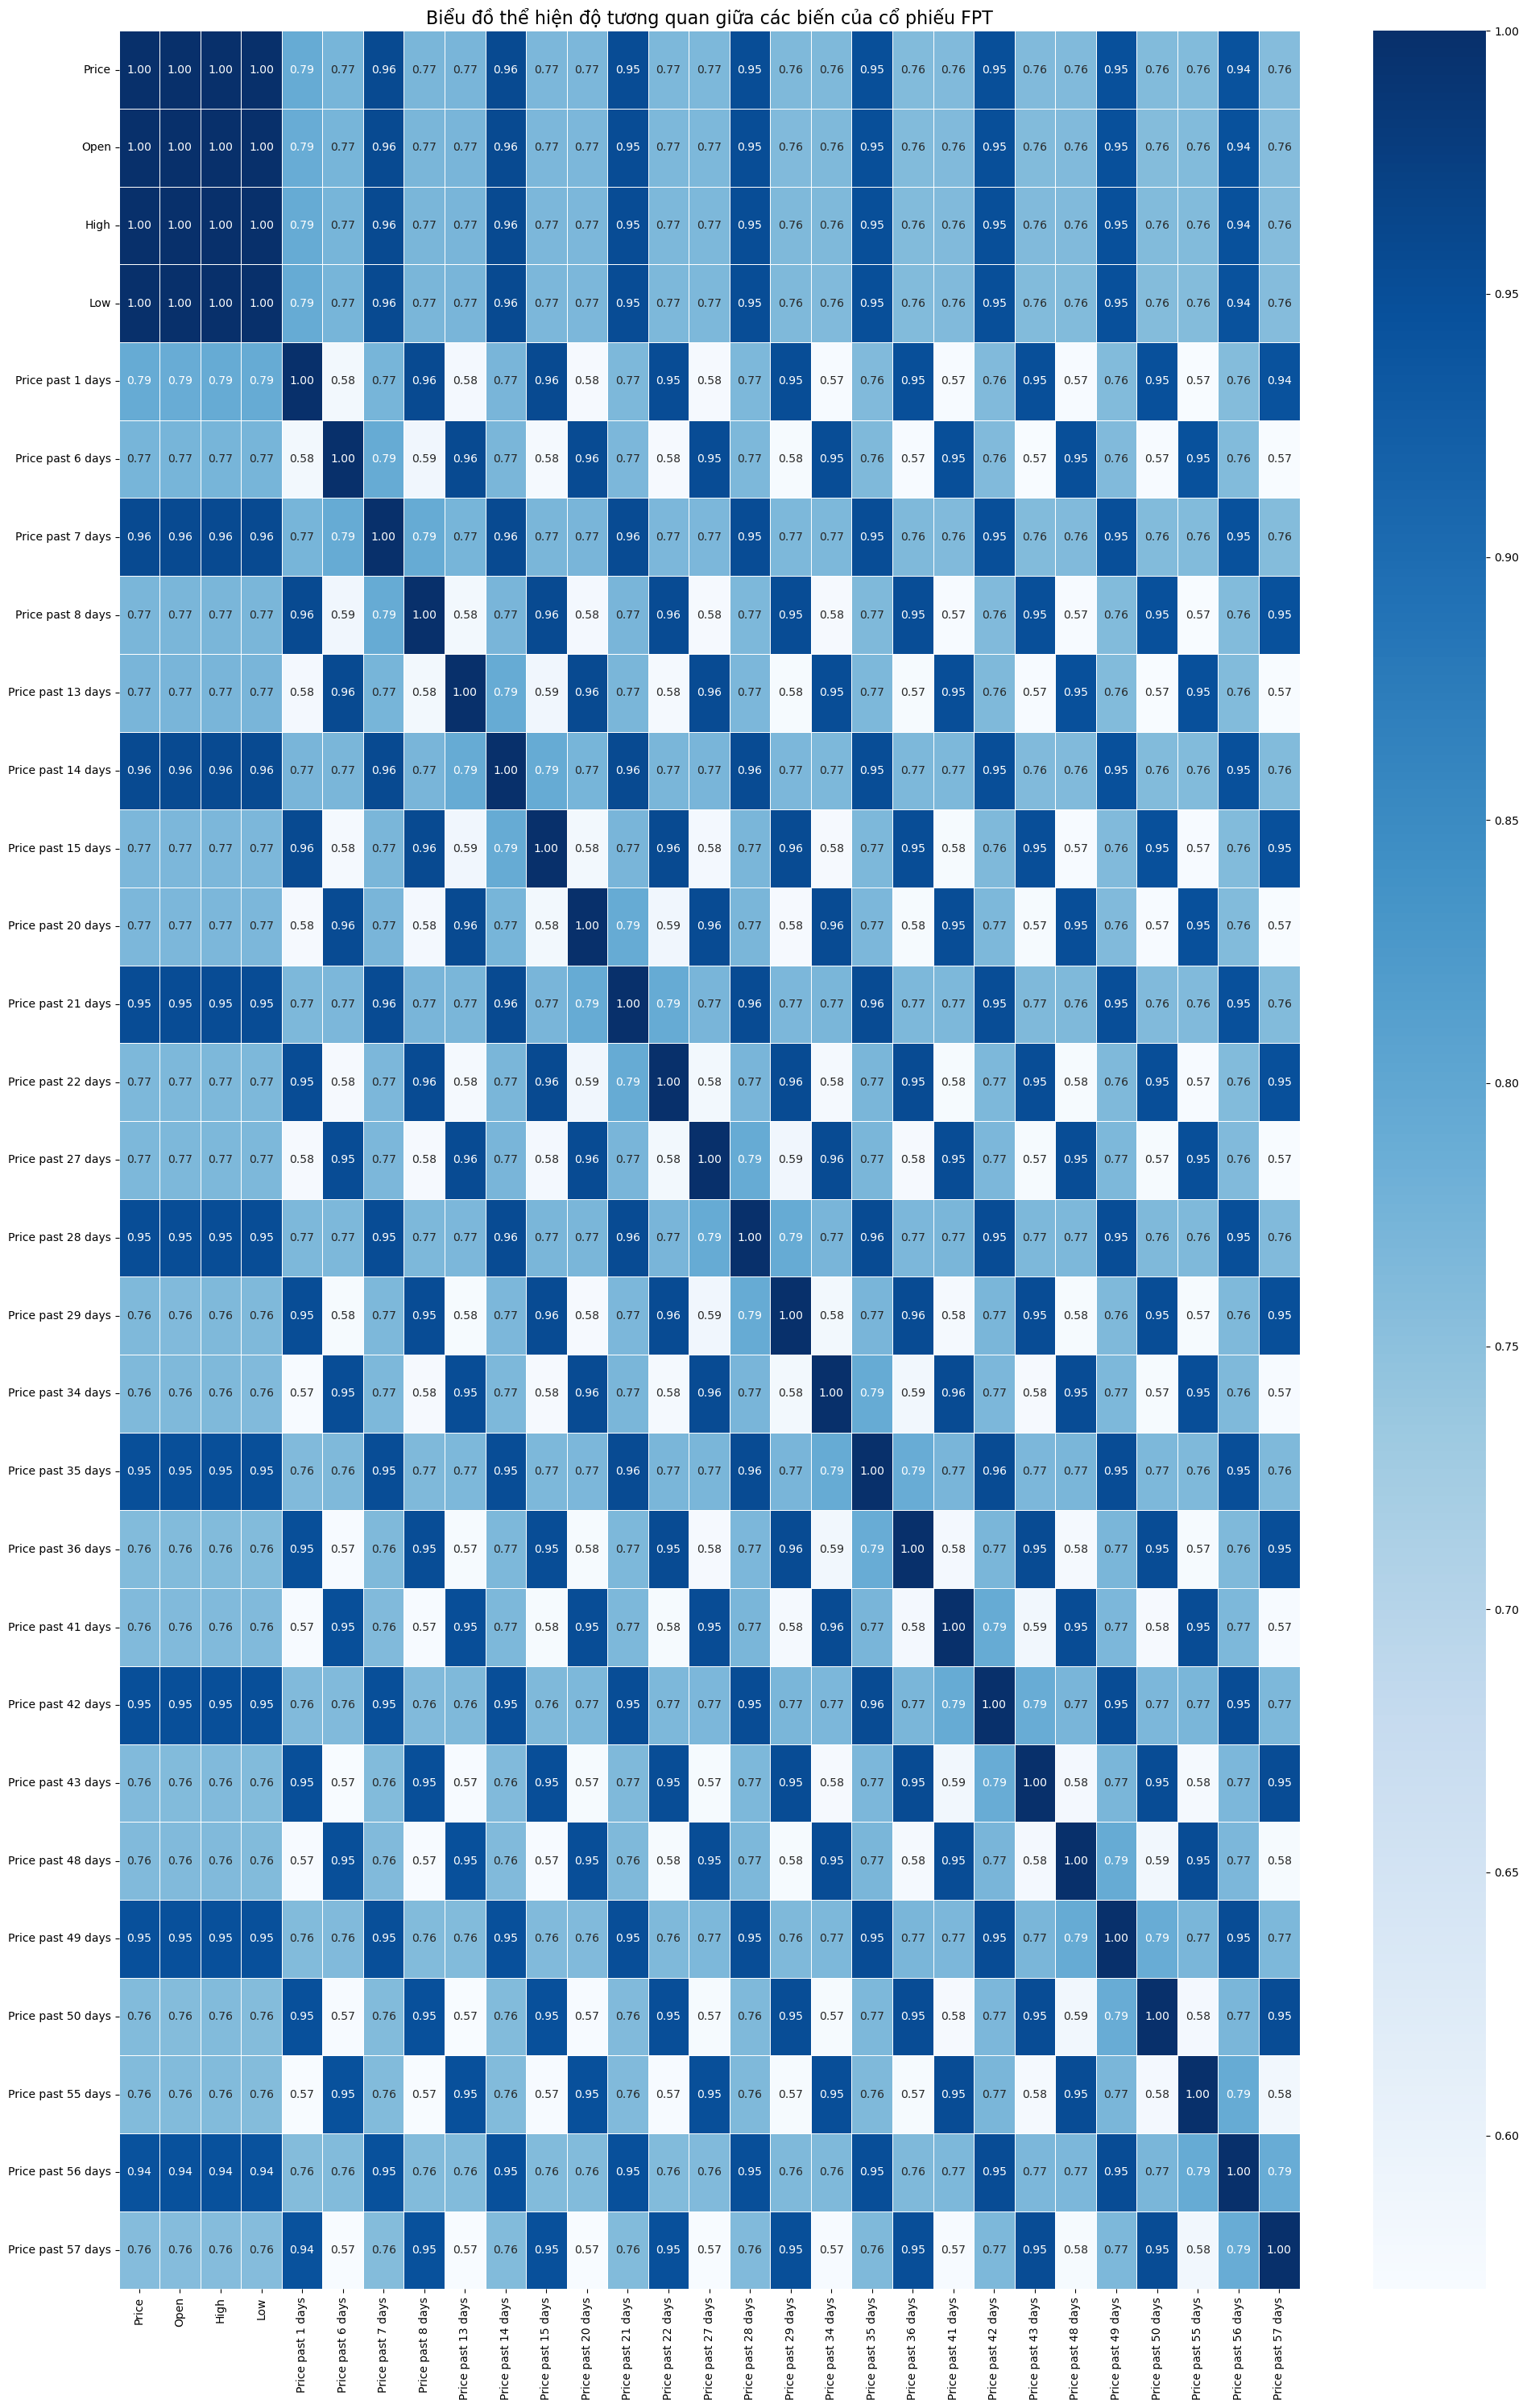

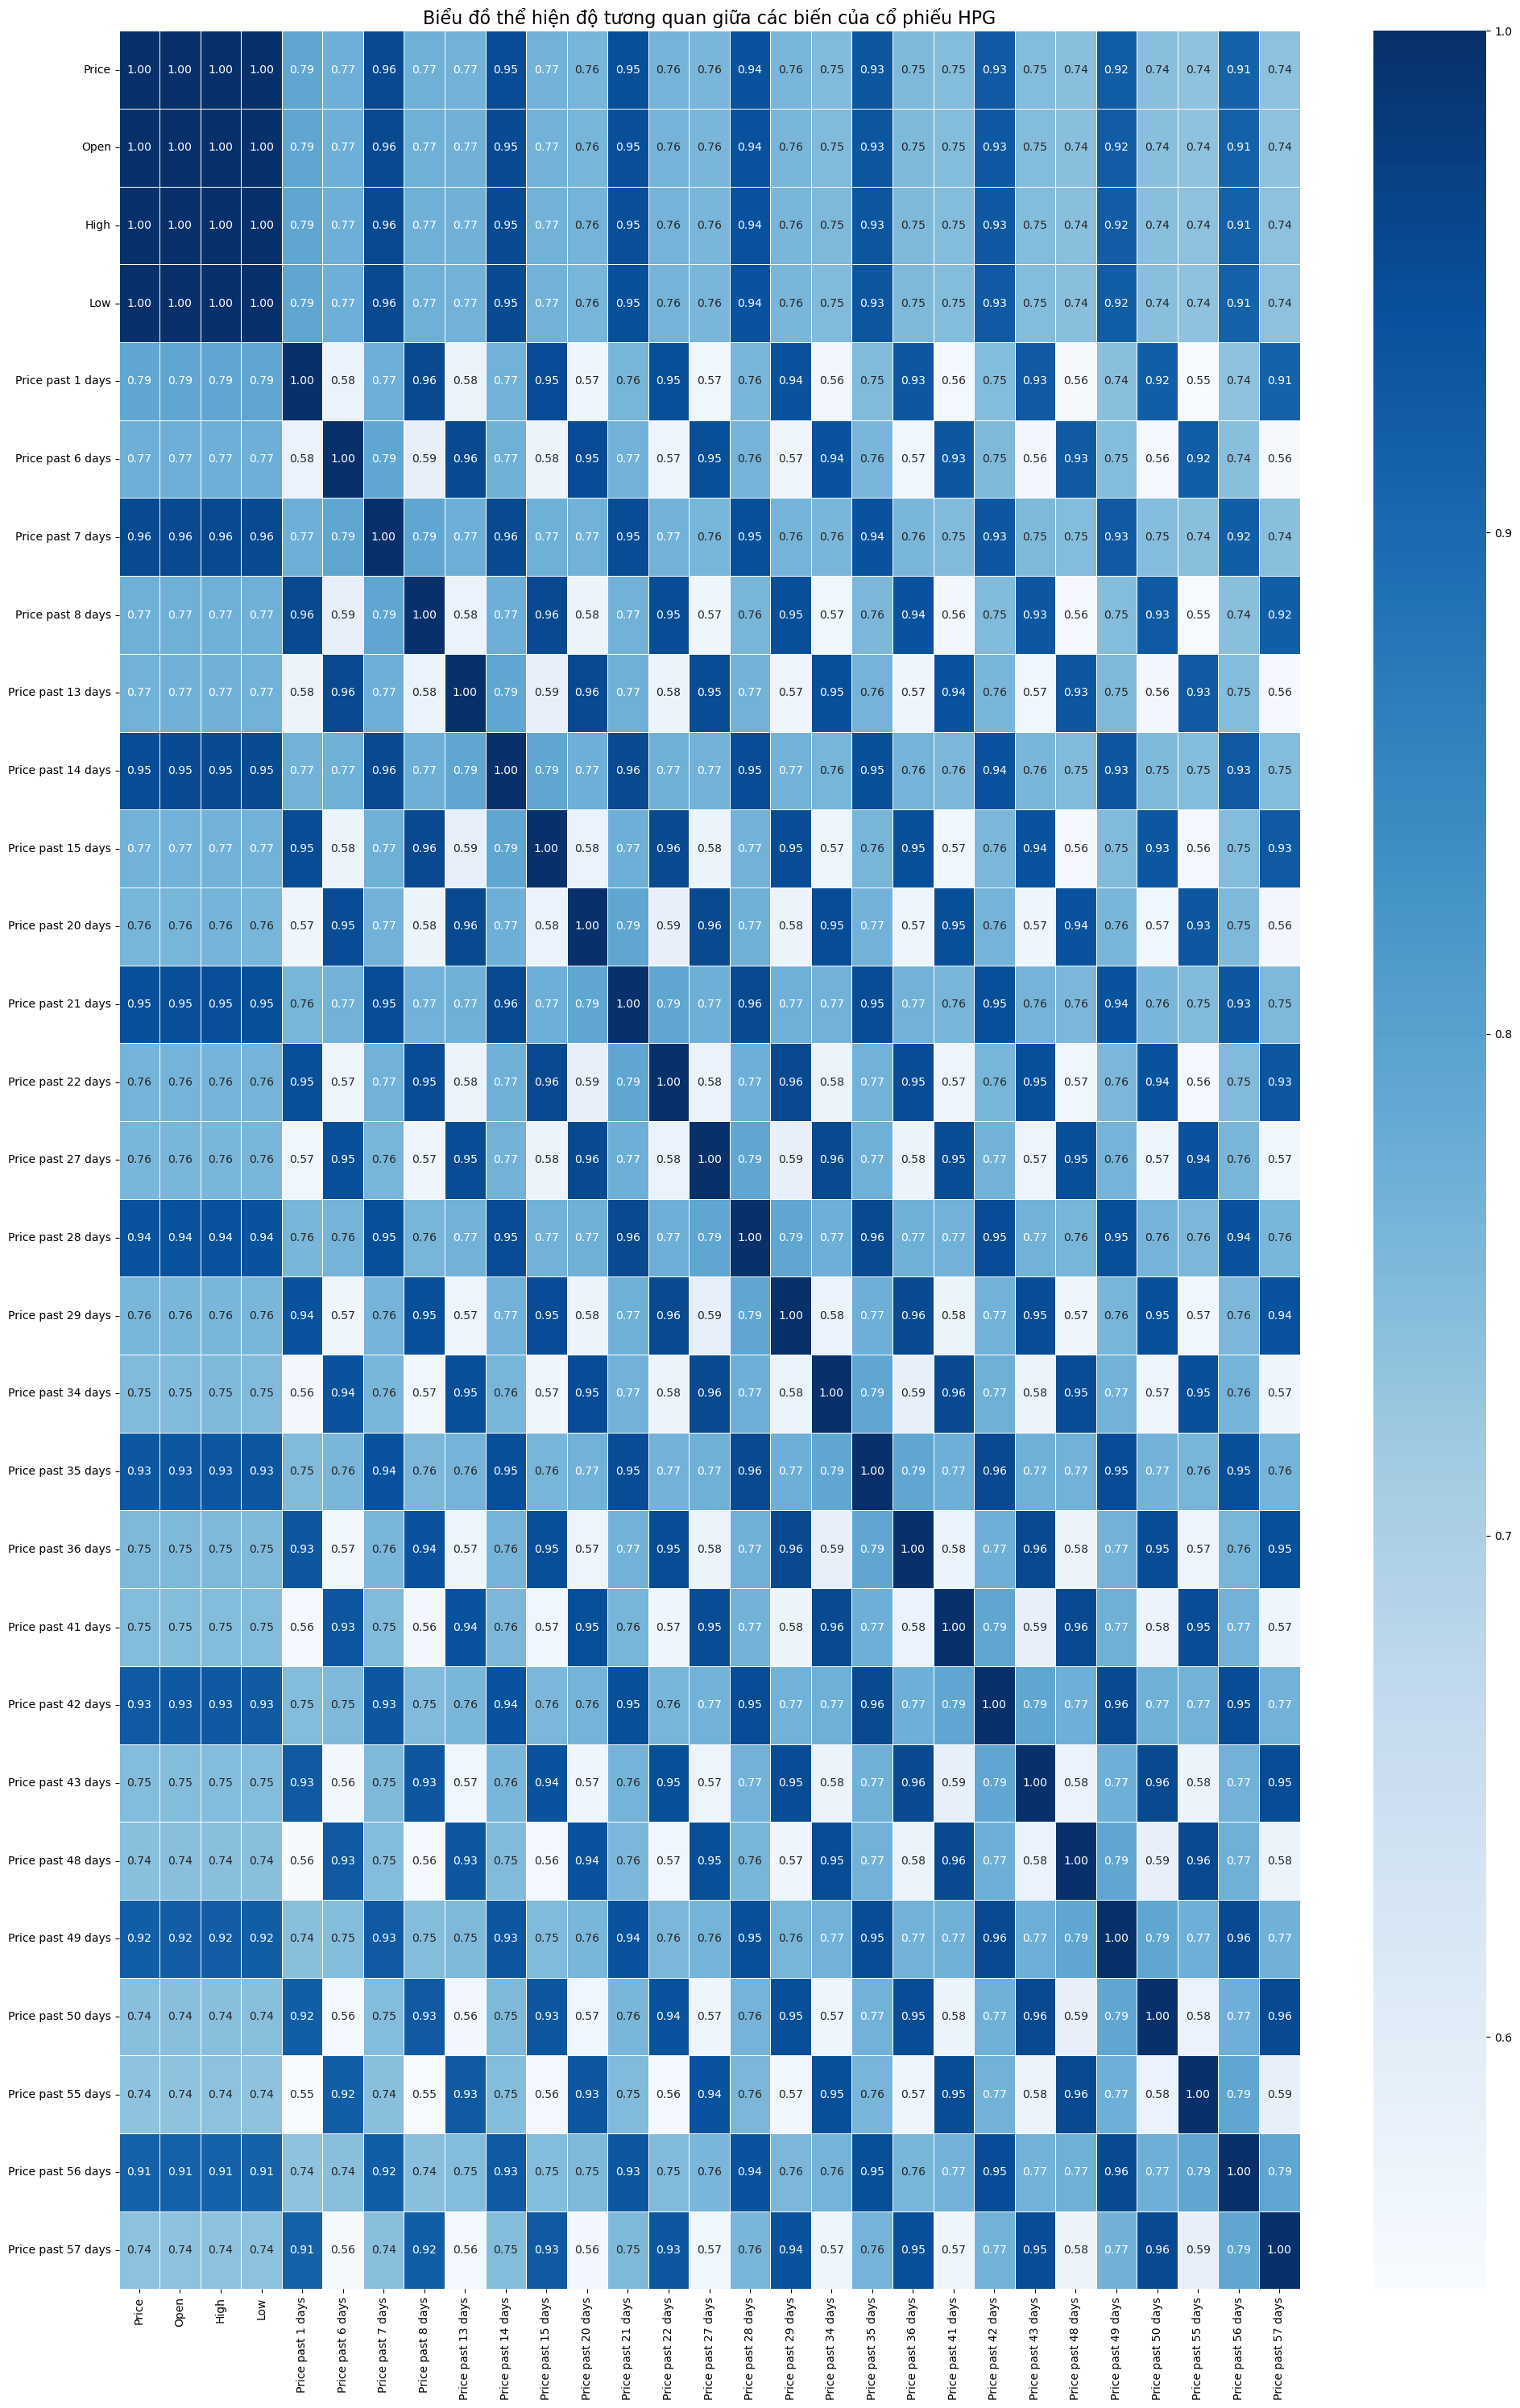

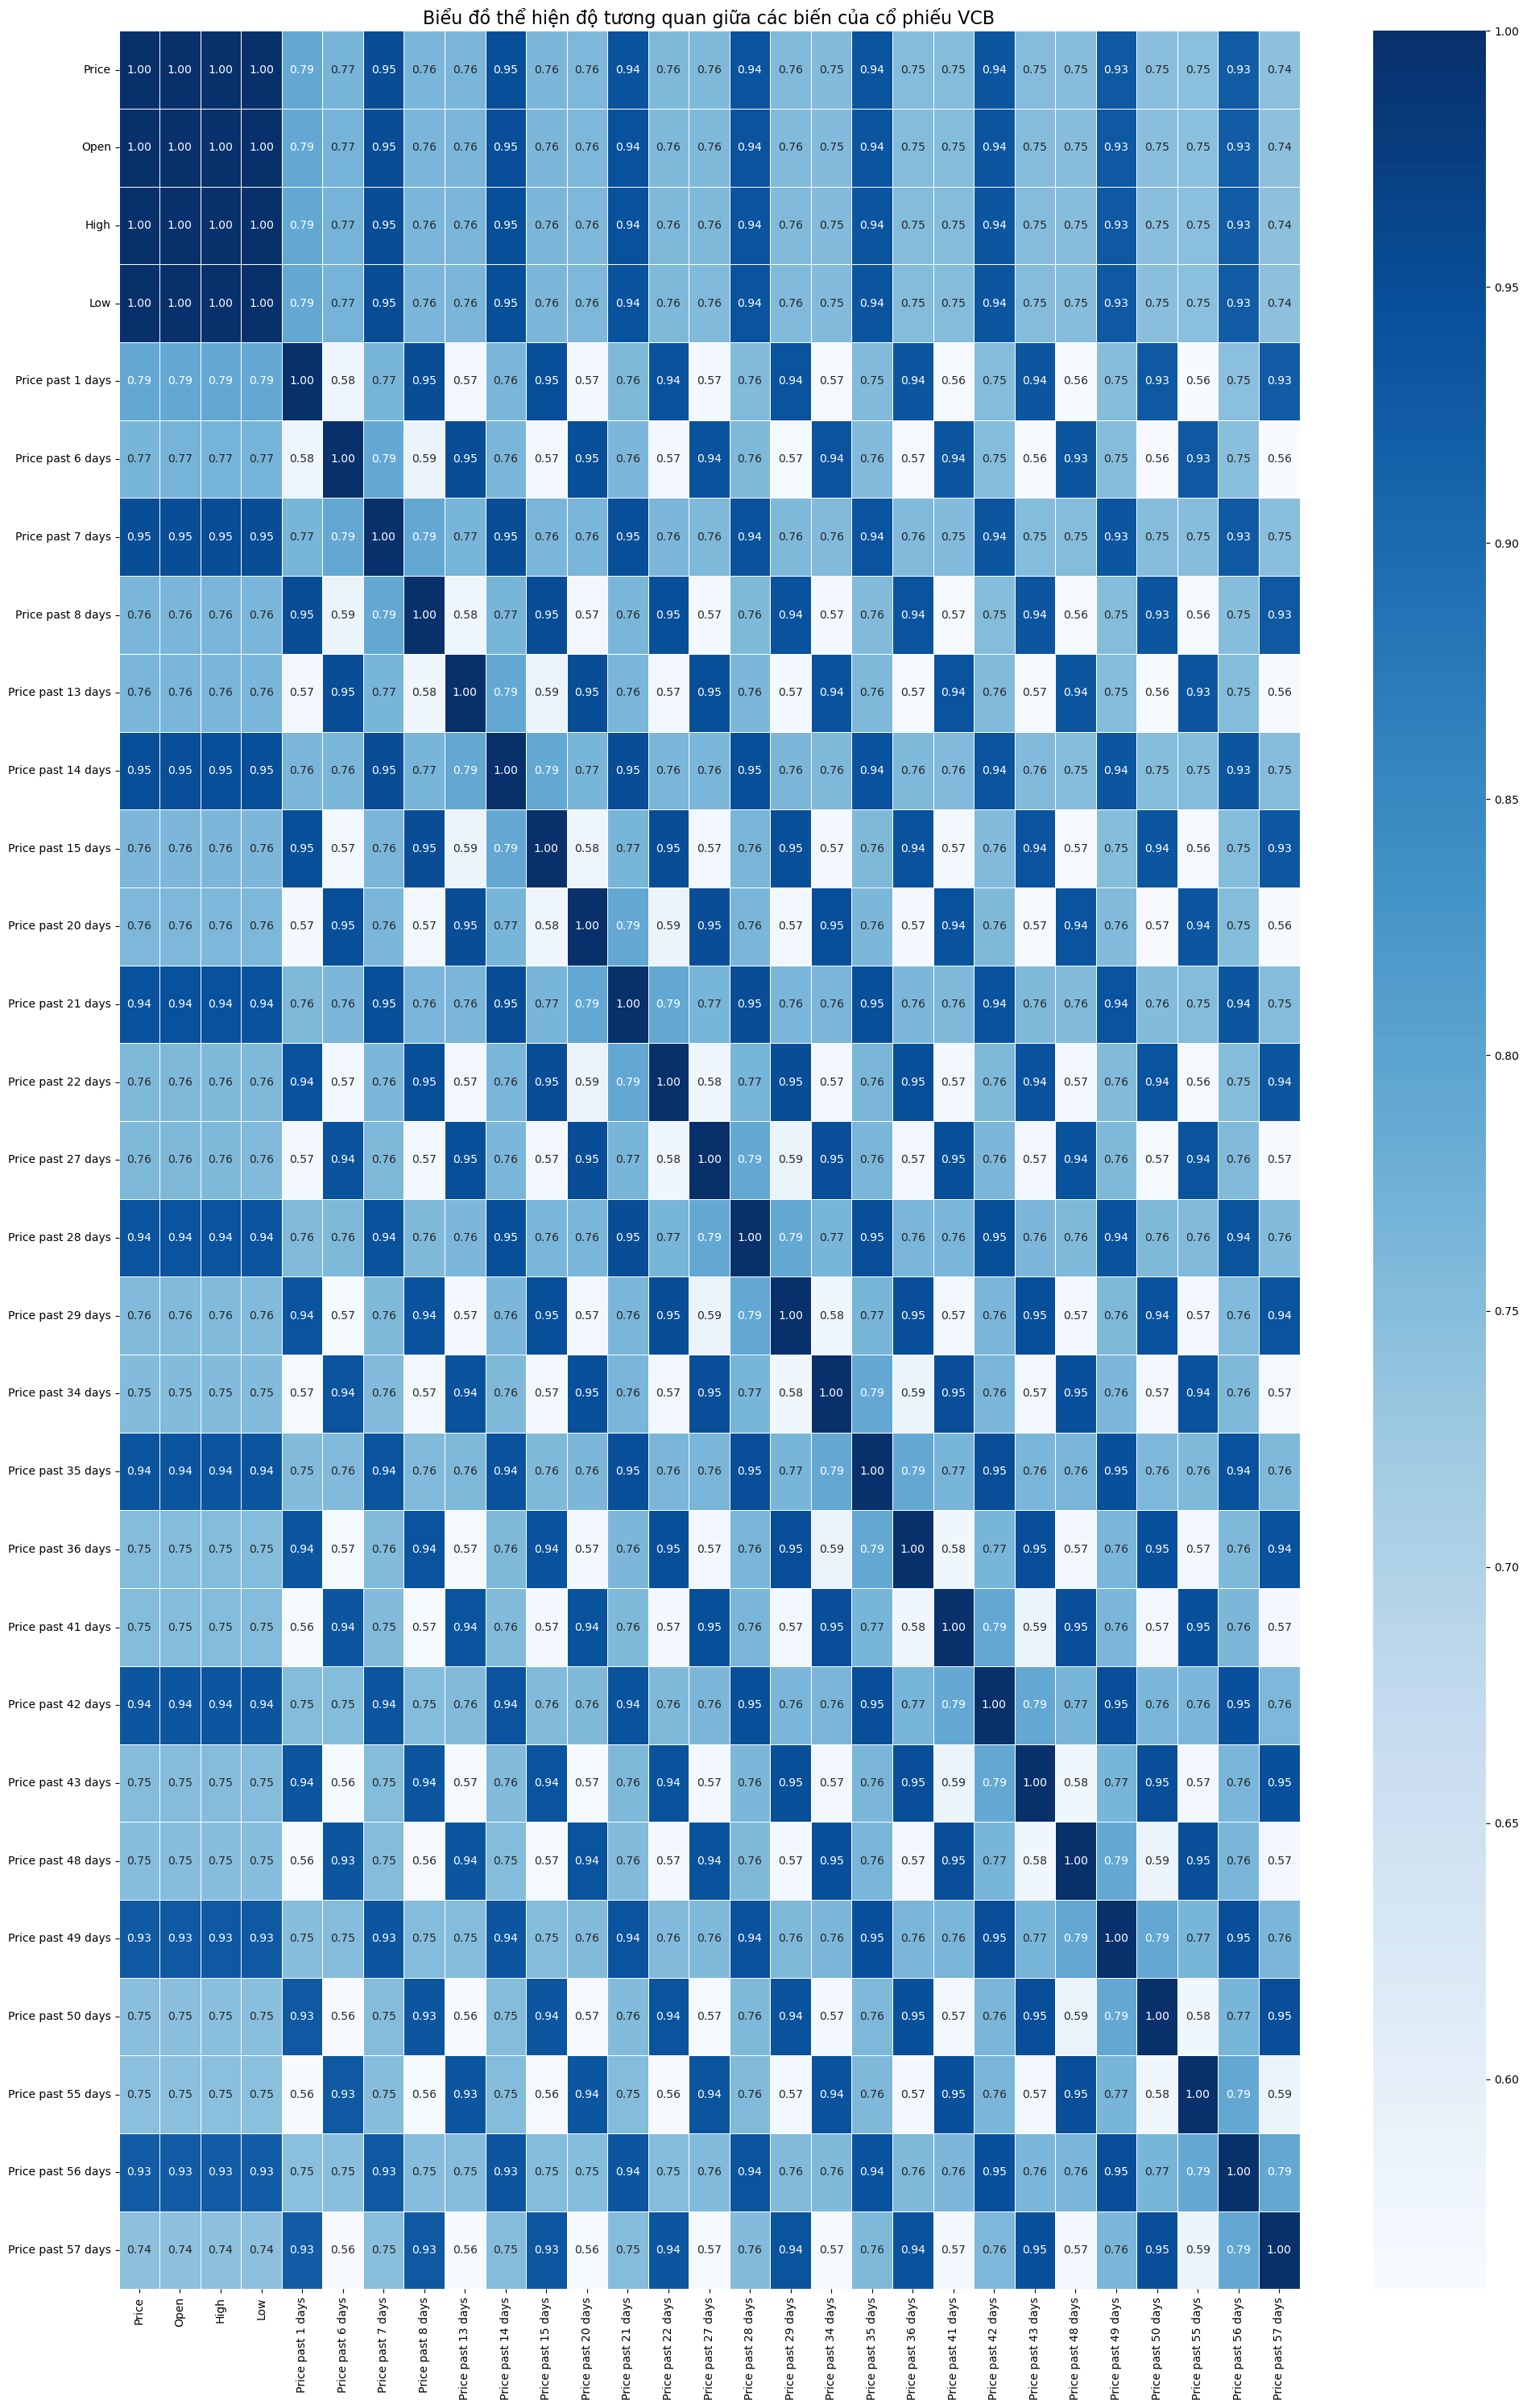

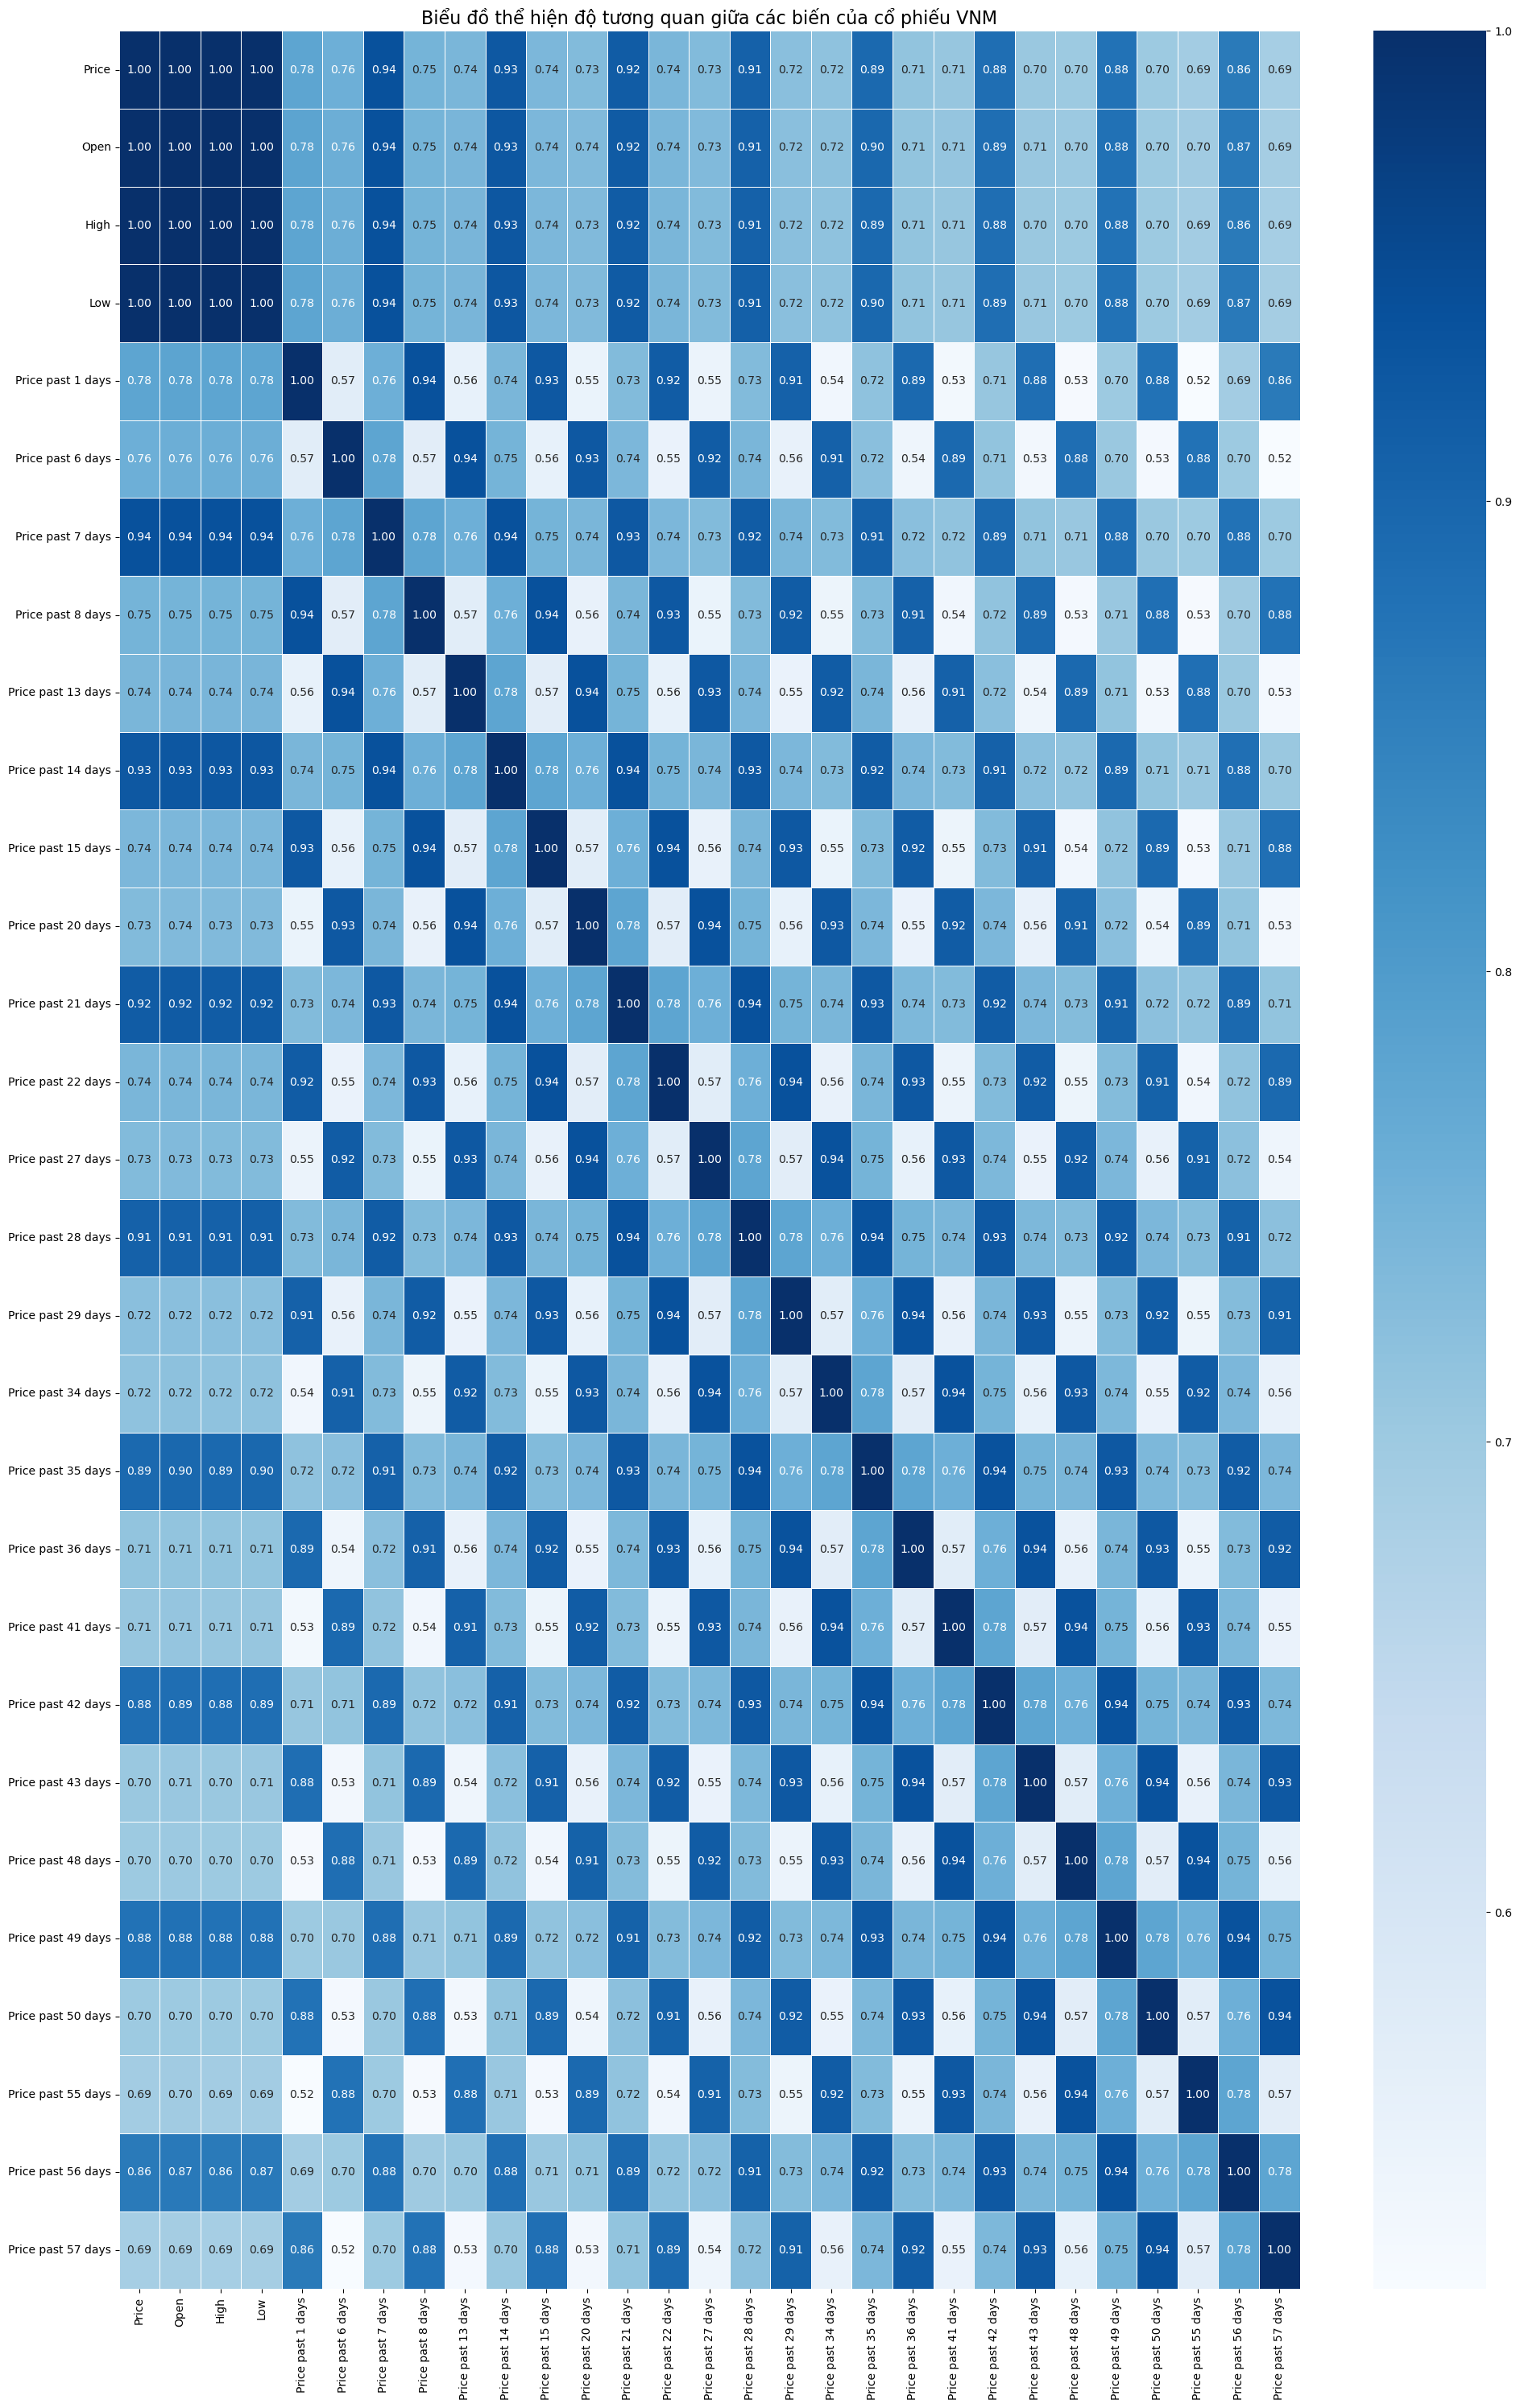

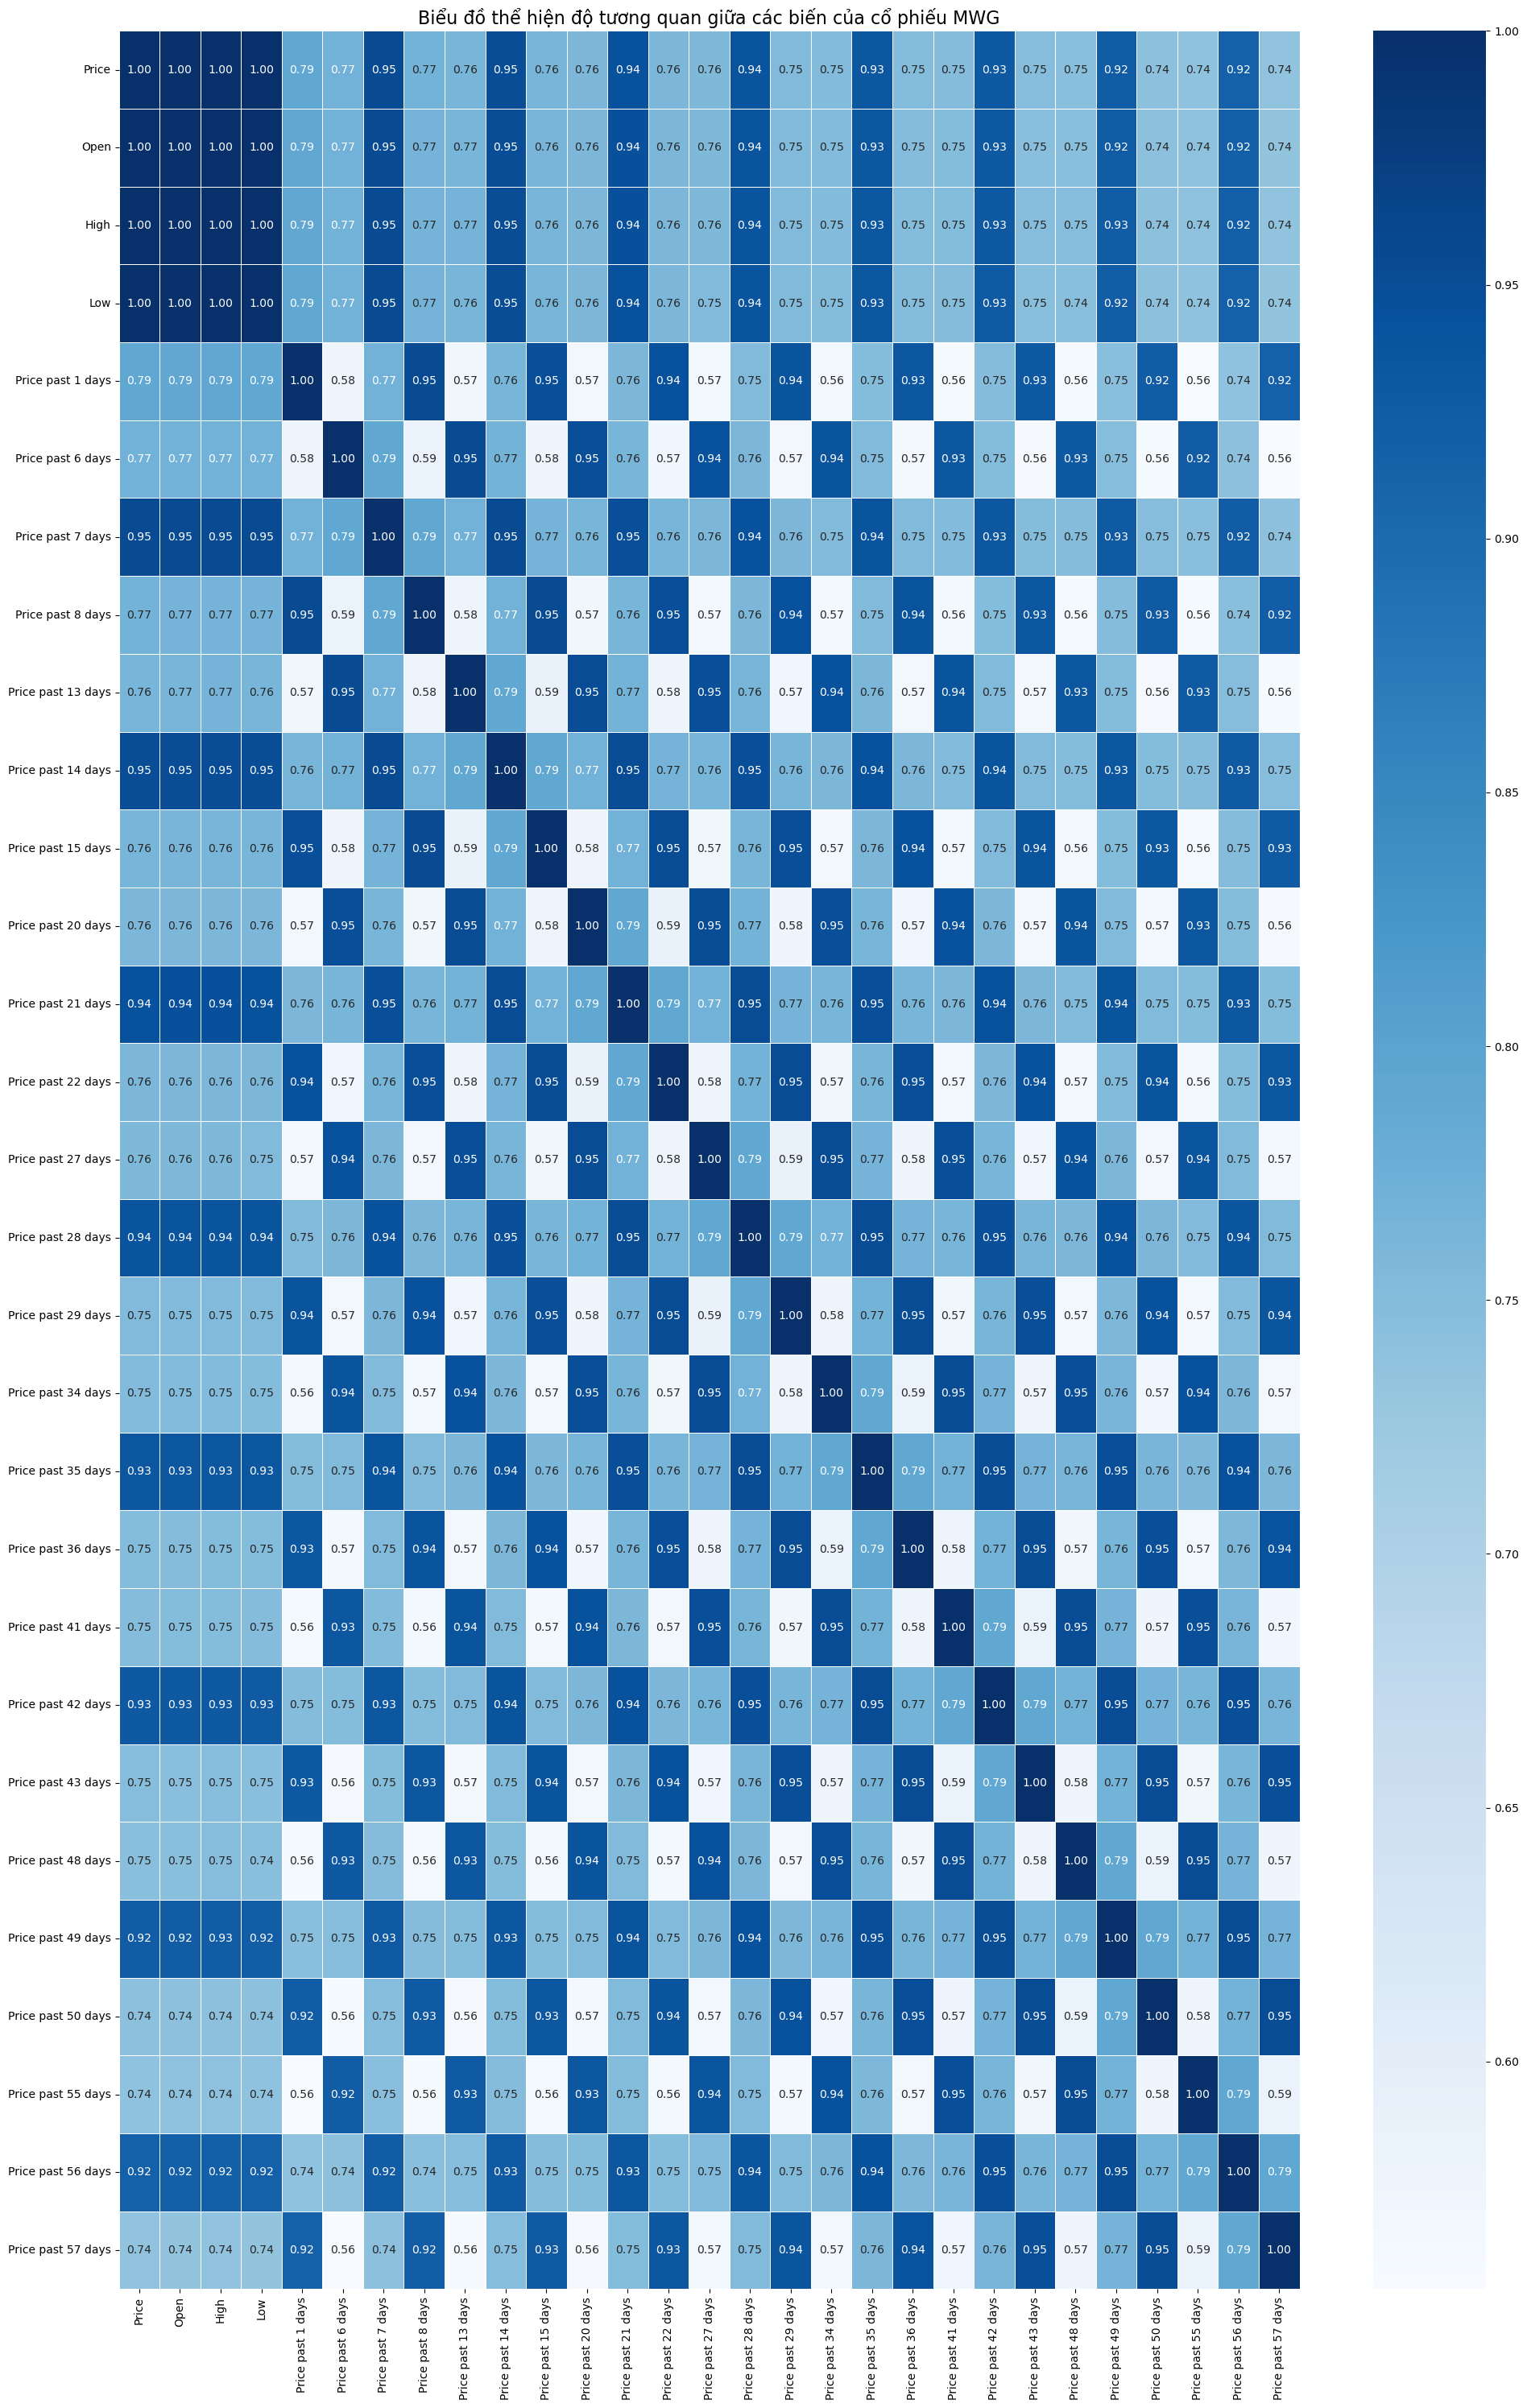

In [50]:
for key,value in stock.items():
    value_corr = value.corr()
    plt.figure(figsize=(20,30))
    sns.heatmap(value_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title(f"Biểu đồ thể hiện độ tương quan giữa các biến của cổ phiếu {key}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Xây dựng các mô hình dự đoán

### Chuẩn bị dữ liệu cho mô hình

In [53]:
for key,value in stock.items():
    stock[key] = value.dropna()
    print(f"Cổ phiếu {key}")
    print(stock[key].head())

Cổ phiếu FPT
               Price      Open      High       Low  Price past 1 days  \
Date                                                                    
2014-10-30 12,497.60 12,497.60 12,622.60 12,497.60          12,497.60   
2014-10-31 12,747.50 12,497.60 12,747.50 12,472.60          12,497.60   
2014-11-01 45,896.54 45,881.92 46,385.08 45,404.60          12,747.50   
2014-11-02 45,896.54 45,881.92 46,385.08 45,404.60          45,896.54   
2014-11-03 12,872.50 12,872.50 12,997.50 12,747.50          45,896.54   

            Price past 6 days  Price past 7 days  Price past 8 days  \
Date                                                                  
2014-10-30          12,447.60          12,472.60          12,622.60   
2014-10-31          45,896.54          12,447.60          12,472.60   
2014-11-01          45,896.54          45,896.54          12,447.60   
2014-11-02          12,172.60          45,896.54          45,896.54   
2014-11-03          12,247.60          12,172.60 

In [54]:
X_dict = {}
y_dict = {}
for key,value in stock.items():
    X = value.drop(columns=['Price'])
    y = value['Price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    X_dict[key] = [X_train, X_test]
    y_dict[key] = [y_train, y_test]

### Chuẩn hóa dữ liệu

In [56]:
def test_scaler(key, X_train, X_test):
    test = {}
    # Standard Scaler
    scaler = StandardScaler()
    test['Standard Scaler'] = [scaler.fit_transform(X_train), scaler.transform(X_test)]
    # MinMax Scaler
    scaler = MinMaxScaler()
    test['MinMax Scaler'] = [scaler.fit_transform(X_train), scaler.transform(X_test)]
    # Robust Scaler
    scaler = RobustScaler()
    test['Robust Scaler'] = [scaler.fit_transform(X_train), scaler.transform(X_test)]
    result ={}
    for k,v in test.items():
        model = LinearRegression()
        model.fit(v[0], y_dict[key][0])
        y_pred = model.predict(v[1])
        model_result = {
            'MSE': round(mean_squared_error(y_dict[key][1], y_pred),2),
            'MAE': round(mean_absolute_error(y_dict[key][1], y_pred),2),
            'R2': round(r2_score(y_dict[key][1], y_pred),2)
        }
        result[k] = model_result
    return result

In [57]:
for key, value in X_dict.items():
    print(f"Cổ phiếu {key}")
    result = test_scaler(key,value[0],value[1])
    result_df = pd.DataFrame(result).T
    print(result_df)  

Cổ phiếu FPT
                       MSE    MAE   R2
Standard Scaler 224,732.71 213.87 1.00
MinMax Scaler   224,732.71 213.87 1.00
Robust Scaler   224,732.71 213.87 1.00
Cổ phiếu HPG
                      MSE   MAE   R2
Standard Scaler 17,756.57 74.01 1.00
MinMax Scaler   17,756.57 74.01 1.00
Robust Scaler   17,756.57 74.01 1.00
Cổ phiếu VCB
                       MSE    MAE   R2
Standard Scaler 186,243.30 251.40 1.00
MinMax Scaler   186,243.30 251.40 1.00
Robust Scaler   186,243.30 251.40 1.00
Cổ phiếu VNM
                       MSE    MAE   R2
Standard Scaler 216,670.76 284.80 1.00
MinMax Scaler   216,670.76 284.80 1.00
Robust Scaler   216,670.76 284.80 1.00
Cổ phiếu MWG
                       MSE    MAE   R2
Standard Scaler 103,062.19 183.01 1.00
MinMax Scaler   103,062.19 183.01 1.00
Robust Scaler   103,062.19 183.01 1.00


Từ bảng kết quả trên cho thấy rằng các phương pháp chuẩn hóa dữ liệu khác nhau đều cho kết quả như nhau. Có thể kết luận là việc chọn phương pháp chuẩn hóa nào cũng sẽ không ảnh hưởng đến chất lượng mô hình. Vì vậy nhóm quyết định lựa chọn Robust Scaler do đây là 1 phương pháp sử dụng **median (trung vị)** và **interquartile range (IQR)** thay vì **mean** và **standard deviation** như các scaler khác. Điều này có nghĩa là phương pháp này sẽ không bị ảnh hưởng bởi giá trị ngoại lệ lớn, các scaler khác như Standard Scaler và MinMax Scaler có thể bị ảnh hưởng, dẫn đến sự biến dạng của dữ liệu sau khi chuẩn hóa. Điều này làm phương pháp này phù hợp với bài toán dự đoán giá cổ phiếu vì dữ liệu giá cổ phiếu hoặc tài chính thường có sự biến động lớn và có thể chứa các điểm ngoại lệ. Hơn nữa, nếu dữ liệu có phân phối lệch hoặc không tuân theo phân phối chuẩn, Robust Scaler có thể hoạt động tốt hơn vì nó không giả định bất kỳ hình dạng phân phối nào.

In [59]:
scaler = RobustScaler()
for key, value in X_dict.items():
    X_dict[key][0] = scaler.fit_transform(value[0])
    X_dict[key][1] = scaler.transform(value[1])

### Mô hình hồi quy tuyến tính (Linear Regression)

In [61]:
# Khởi tạo mô hình
model = LinearRegression()
# Dự đoán
y_pred=model.predict(X_test)

mse=mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:",mae)
print("R-squared Score:", r2)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Đồ thị so sánh kết quả của 100 ngày giao dịch gần nhất
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-100:], label='Actual Prices', linestyle='-', marker='o', markersize=4, linewidth=1.5, color='blue')
plt.plot(y_pred[-100:], label='Predicted Prices', linestyle='--', marker='x', markersize=4, linewidth=1.5, color='orange')
plt.legend()
plt.xlabel('Index (Last 100 Data Points)')
plt.ylabel('Stock Prices')
plt.title('Actual vs Predicted Prices (Last 100 Data Points)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Trích xuất các hệ số của mô hình
weights = model.coef_
intercept = model.intercept_
print(f"Hệ số chặn: {intercept}")

feature_names = X.columns  
weights_with_features = list(zip(feature_names, weights))

# Sắp xếp các hệ số theo thứ tự giảm dần
sorted_weights = sorted(weights_with_features, key=lambda x: abs(x[1]), reverse=True)

for feature, weight in sorted_weights:
    print(f"Feature: {feature}, Weight: {weight}")

In [ ]:
error

# Testing

In [ ]:
X=stock[['Past Price','High','Low','Open','Vol.']]
y=stock['Price']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42)
# Khởi tạo mô hình
model=LinearRegression()
model.fit(X_train, y_train)

# Dự đoán
y_pred=model.predict(X_test)

# Đánh giá mô hình
mse=mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:",mae)
print("R-squared Score:", r2)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-100:], label='Actual Prices', linestyle='-', marker='o', markersize=4, linewidth=1.5, color='blue')
plt.plot(y_pred[-100:], label='Predicted Prices', linestyle='--', marker='x', markersize=4, linewidth=1.5, color='orange')
plt.legend()
plt.xlabel('Index (Last 100 Data Points)')
plt.ylabel('Stock Prices')
plt.title('Actual vs Predicted Prices (Last 100 Data Points)')
plt.grid(True)
plt.tight_layout()
plt.show()
# Trích xuất các hệ số của mô hình
weights = model.coef_
intercept = model.intercept_
print(f"Hệ số chặn: {intercept}")

feature_names = X_train.columns  
weights_with_features = list(zip(feature_names, weights))

# Sắp xếp các hệ số theo thứ tự giảm dần
sorted_weights = sorted(weights_with_features, key=lambda x: abs(x[1]), reverse=True)

for feature, weight in sorted_weights:
    print(f"Feature: {feature}, Weight: {weight}")

In [ ]:
stock['HPG']

In [ ]:
def detect_outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers
def test_transform_outlier(x):
    test = {}
    # Loại bỏ các giá trị ngoại lai
    x_copy = x.drop(columns='Price').copy()
    for col in x_copy.columns.to_list():
        x_copy = x_copy[~x_copy[col].isin(detect_outliers_iqr(x_copy[col]))]
    test['Del'] = x_copy
    # MinMax Scaler
    x_copy = x.drop(columns='Price').copy()
    scaler = MinMaxScaler()
    test['MinMax'] = pd.DataFrame(scaler.fit_transform(x_copy), columns=x_copy.columns)
    # Standard Scaler
    x_copy = x.drop(columns='Price').copy()
    scaler = StandardScaler()
    test['Standard'] = pd.DataFrame(scaler.fit_transform(x_copy), columns=x_copy.columns)
    # Robust Scaler
    x_copy = x.drop(columns='Price').copy()
    scaler = RobustScaler()
    test['Robust'] = pd.DataFrame(scaler.fit_transform(x_copy), columns=x_copy.columns)
    result ={}
    for key, item in test.items():
        X = item
        y = x['Price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_result = {
            'MSE': round(mean_squared_error(y_test, y_pred),2),
            'MAE': round(mean_absolute_error(y_test, y_pred),2),
            'R2': round(r2_score(y_test, y_pred),2)
        }
        result[key] = model_result
    return result